In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics 
import matplotlib.pyplot as plt
from random import gauss
from random import seed
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from dtaidistance import dtw
from collections import Counter
import time
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from scipy.optimize import fmin
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import interp
from scipy.stats import entropy
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.calibration import CalibratedClassifierCV


# Helper Functions
def get_auc(df):
    auc_values = []
    for i in range(0, len(df.index)):
        row = df.iloc[i]
        x = df.columns.values.astype(float)
        y = row.values
        auc_values.append(metrics.auc(x, y))
    return pd.Series(auc_values, index=df.index)

def get_roc(labels, scores):    
    fpr, tpr, thresholds = roc_curve(labels, scores)  
    threshold = thresholds[np.argmax(tpr - fpr)]
    return fpr, tpr, thresholds, auc(fpr, tpr), threshold

def get_thresh(tpr,fpr,thresholds):
    youden = np.argmax(tpr - fpr)
    thresh = thresholds[youden]
    fpr_thresh = fpr[youden]
    tpr_thresh = tpr[youden]
    return thresh, fpr_thresh, tpr_thresh 

# Used to find nearest threshold
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    print('nearest difference:', min(np.abs(array - value))) # to make sure differences aren't too big
#     print(array[idx])
    return idx

# Ignore warnings
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=SettingWithCopyWarning) 

# Folder to save data

In [102]:
save_folder = 'Lennart Figures/LOO classifier comparison6/dropEc/'

# Import Melt Curves

In [3]:
df_all_alignedbyOrg_1 = pd.read_csv('C:/Users/FraleyLab/Documents/df_all_alignedbyOrg_1.csv', index_col=0)

df_all_alignedbyOrg_1_fillnan = df_all_alignedbyOrg_1.replace(np.nan, 0)
all_alignedbyOrg_1_auc = get_auc(df_all_alignedbyOrg_1_fillnan)
df_all_alignedbyOrg_1_auc_norm = df_all_alignedbyOrg_1_fillnan.divide(all_alignedbyOrg_1_auc, axis=0)
print(df_all_alignedbyOrg_1_auc_norm.shape)

(18893, 410)


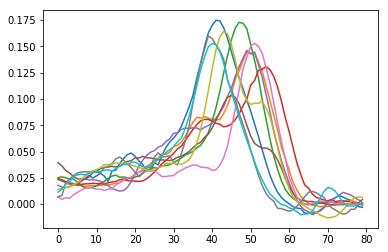

In [58]:
# [plt.plot(range(400), df_all_alignedbyOrg_1_auc_norm.values[i][:400]) for i in range(10)]
# [plt.plot(range(70), df_all_alignedbyOrg_1_auc_norm.iloc[:,330:-10].values[i]) for i in range(10)]
[plt.plot(range(80), df_all_alignedbyOrg_1_auc_norm.iloc[:,330:].values[i]) for i in range(10)]

plt.show()

# Alternative set - 1 chip per organism

In [3]:
# Import all organism data and plot average melt curve
df_GBS = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Meltcurves from Augustine/goodDer/20171128_GBS_C0AAFO_Run1_goodDerMelt.csv')
df_SG = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Meltcurves from Augustine/goodDer/20180103_SGallo_C0CMZV_Run1_goodDerMelt.csv')
df_CK = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Meltcurves from Augustine/goodDer/20180104_CKoseri_C0C5UX_Run1_goodDerMelt.csv')
df_L = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Meltcurves from Augustine/goodDer/20171221_Listeria_C0CG0H_Run1_goodDerMelt.csv')
df_HI = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Meltcurves from Augustine/goodDer/20171206_HInfluenzae_C0BZ9Q_Run1_goodDerMelt.csv')
df_SS = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Meltcurves from Augustine/goodDer/20171129_Ssanguinis_C09J24_Run1_goodDerMelt.csv')
df_MSSA = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Meltcurves from Augustine/goodDer/20171221_MSSA_C0CD12_Run1_goodDerMelt.csv')
df_SP = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Meltcurves from Augustine/goodDer/20171206_StrepPneumo_C0B4VU_Run1_goodDerMelt.csv')
df_EF = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Meltcurves from Augustine/goodDer/20171207_Efaecium_C0C2Q0_Run1_goodDerMelt.csv')
df_EC = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Meltcurves from Augustine/goodDer/20171221_Ecoli_C0C2ZD_Run1_goodDerMelt.csv')

In [8]:
dfs = [df_GBS, df_SG, df_CK, df_L, df_HI, df_SS, df_MSSA, df_SP, df_EF, df_EC]

In [9]:
# labels = ["$\it{C. koseri}$", "$\it{E. coli}$", "$\it{E. faecium}$", "$\it{Group\ B\ Strep.}$", "$\it{H. influenzae}$", 
#           "$\it{L. monocytogenes}$", "$\it{S. aureus}$", "$\it{S. gallolyticus}$", "$\it{S. sanguinis}$", "$\it{S. pneumoniae}$"]

labels = ['S. agalactiae', 'S. gallolyticus', 'C. koseri', 'L. monocytogenes', 'H. influenzae', 'S. sanguinis', 'S. aureus', 'S. pneumoniae', 'E. faecium', 'E. coli'] 

In [10]:
for label,df in zip(labels,dfs):
    df.index = [label for i in range(len(df))]

In [24]:
all_dfs = df_GBS.copy()
for df in dfs[1:]:
    all_dfs = pd.concat([all_dfs,df])
print(all_dfs.shape)
all_dfs

(18281, 410)


,51.1,51.2,51.3,51.4,51.5,51.6,51.7,51.8,51.9,52,...,91.1,91.2,91.3,91.4,91.5,91.6,91.7,91.8,91.9,92
S. agalactiae,0.038317,0.042832,0.041720,0.048647,0.053962,0.055333,0.059399,0.057421,0.052632,0.050348,...,0.003574,0.004326,-0.004036,-0.000852,0.000655,0.000257,0.002540,0.001824,0.000942,0.000020
S. agalactiae,0.038333,0.038619,0.040395,0.045103,0.045592,0.047299,0.043471,0.044084,0.041716,0.042780,...,0.017946,0.014233,0.012760,0.012274,-0.000199,0.001698,-0.000018,-0.001463,-0.003027,-0.004778
S. agalactiae,0.039959,0.038495,0.037891,0.039467,0.037806,0.038973,0.042207,0.044875,0.044164,0.045857,...,0.003018,0.002435,-0.000222,0.000739,0.001545,0.002198,0.001673,0.001183,0.000418,-0.000194
S. agalactiae,0.044246,0.042995,0.045498,0.043733,0.040161,0.035979,0.028586,0.023834,0.022911,0.025907,...,0.003072,0.009320,0.012643,0.015321,0.015170,0.010764,0.005123,0.001088,-0.003737,-0.006523
S. agalactiae,0.048960,0.045114,0.042020,0.039651,0.043238,0.044118,0.045285,0.047385,0.044522,0.039250,...,-0.008164,-0.003874,-0.002117,0.000412,0.003063,0.003394,0.002567,0.001216,-0.000699,-0.001216
S. agalactiae,0.043058,0.049088,0.054906,0.058309,0.057185,0.056283,0.053997,0.049214,0.043469,0.039380,...,-0.005267,-0.004037,0.000517,0.001319,0.001368,-0.000790,-0.001603,-0.003346,-0.005622,-0.005846
S. agalactiae,0.047903,0.050282,0.046895,0.044151,0.042551,0.038005,0.033193,0.036874,0.037140,0.039517,...,-0.007657,-0.004257,-0.002108,-0.000107,0.001284,0.001042,0.000385,-0.000112,-0.000996,-0.002102
S. agalactiae,0.041561,0.042348,0.042982,0.042463,0.045456,0.046360,0.045331,0.042953,0.039064,0.035388,...,0.022167,0.017860,0.017525,0.012478,0.010647,0.000059,0.002470,0.002595,0.002890,0.002806
S. agalactiae,0.053605,0.055325,0.059931,0.058280,0.050027,0.043352,0.037607,0.033130,0.031054,0.031974,...,0.000169,0.001309,0.000078,0.000723,0.001425,0.001240,0.000592,-0.000372,-0.001822,-0.003324
S. agalactiae,0.035549,0.035958,0.038294,0.040545,0.046282,0.048462,0.048617,0.052732,0.051474,0.047987,...,0.027419,0.029906,0.026765,0.021984,0.015170,0.008918,0.001981,-0.003270,-0.005500,-0.007786


In [34]:
# Weight each experiment with # novel curves (= size of left-out class)
balance_unknown = compute_sample_weight(class_weight='balanced', y=all_dfs.index)
_, idx = np.unique(balance_unknown, return_index=True)
weight_experiments = balance_unknown[np.sort(idx)]
print(weight_experiments)

print([len(df) for df in dfs])

dfs10weights = pd.DataFrame()
dfs10weights['Nr. Curves'] = [len(df) for df in dfs]
dfs10weights['Weight'] = weight_experiments
dfs10weights.index = labels
dfs10weights.to_csv('dfs10weights.csv')
dfs10weights

[0.81285016 0.91131605 0.89088694 0.81466132 0.80710817 0.83019982
 0.90142998 1.45665339 1.60782762 2.16856465]
[2249, 2006, 2052, 2244, 2265, 2202, 2028, 1255, 1137, 843]


,Nr. Curves,Weight
S. agalactiae,2249,0.812850
S. gallolyticus,2006,0.911316
C. koseri,2052,0.890887
L. monocytogenes,2244,0.814661
H. influenzae,2265,0.807108
S. sanguinis,2202,0.830200
S. aureus,2028,0.901430
S. pneumoniae,1255,1.456653
E. faecium,1137,1.607828
E. coli,843,2.168565


# Define Classifiers

In [26]:
# Logistic Regression
class_weights = [None, 'balanced']
class_weights = [None] # Don't use extra options for now
LR_classifiers = [LogisticRegression(random_state=42, multi_class="multinomial",solver='newton-cg', penalty='l2', class_weight=cw, n_jobs=-1) for cw in class_weights]  
LR_names = ['LogisticRegression, class_weights=%s' %cw for cw in class_weights] 
LR_names = ['LogisticRegression'] 

# Support Vector Machine (SVM)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kernels = ['rbf', 'linear'] # These are the best performing ones
SVM_classifiers = [SVC(kernel=kernel, probability=True, random_state=42) for kernel in kernels]  
SVM_names = ['SVM kernel=%s' %kernel for kernel in kernels] 

# Neural Network, Multi-layer Perceptron (MLP)
activation = ['identity', 'logistic', 'tanh', 'relu']
MLP_classifiers = [MLPClassifier(activation=act, random_state=42) for act in activation]  
MLP_names = ['Neural net activation=%s' %act for act in activation]  

# Random Forest
RandF_classifiers = [RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1) for n in [50,100,500]]
RandF_names = ['RandF n=%s' %str(n) for n in [50,100,500]]

# Naive Bayes
NB_classifiers = [GaussianNB(), CalibratedClassifierCV(base_estimator=GaussianNB(), cv=5)]
NB_names = ['Gaussian NB', 'Gaussian NB, calibrated']

#kNN ED and DTW
kNN_classifiers = [KNeighborsTimeSeriesClassifier(n_neighbors=1, metric='euclidean', n_jobs=-1), 
                   KNeighborsTimeSeriesClassifier(n_neighbors=1, metric='euclidean', weights='distance', n_jobs=-1),
                   KNeighborsTimeSeriesClassifier(n_neighbors=1, metric='softdtw', n_jobs=-1), 
                   KNeighborsTimeSeriesClassifier(n_neighbors=1, metric='softdtw', weights='distance', n_jobs=-1)]
kNN_names = ['1NN-ED', '1NN-ED weighted','1NN-softDTW', '1NN-softDTW weighted']

# Classifiers
classifiers = LR_classifiers + NB_classifiers + SVM_classifiers + MLP_classifiers + RandF_classifiers  #+ kNN_classifiers
classifiers_names = LR_names + NB_names + SVM_names + MLP_names + RandF_names  #+ kNN_names

# Main Method
1. 10x Leave-One-Out (10x LOO)
    1. probability 
    2. entropy 
2. Accumulate those 10 experiments to get novelty threshold 
    1. weights = None 
    2. each experiment is weighted to balance 0's and 1's 
    3. the accumulated experiment is weighted to balance 0's and 1's 
    4. each experiment is weighted by #novel curves (= size of leave-one-out species) 
3. Use novelty threshold on uMelt validation dataset
    1. Compare to optimal threshold

# 1) 10x LOO

In [93]:
from sklearn.calibration import CalibratedClassifierCV

In [106]:
# labels = list(np.unique(df_all_alignedbyOrg_1_auc_norm.index.values))

# These are background subtracted aligned to 0
all_dfs = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Publications/2. Probabilistic novelty detection/Data/all_dfs.csv', index_col=0)

save = []
accumulate = []
roc_curves = []
test_size = []
fig_save = []
for z,df in enumerate([all_dfs.drop('E. coli'), all_dfs.drop('E. coli').iloc[:,240:], all_dfs.drop('E. coli'), all_dfs.drop('E. coli').iloc[:,240:], all_dfs.drop('E. coli'), all_dfs.drop('E. coli').iloc[:,240:]]):  #[all_dfs.drop('E. coli'), all_dfs.drop('E. coli').iloc[:,240:]]
    for label in labels[:-1]: # Leave-one-out loop
        label_time = time.time()
        print(label)

        df_LOO = df.drop(label)
        X_train, X_test, y_train, y_test = train_test_split(df_LOO, df_LOO.index, test_size=0.2, random_state=42)
        known_length = len(X_test)
        unknown_length = len(df.loc[label])
        test_size.append([label,known_length,unknown_length])

        X_test = X_test.append(df.loc[label])
        y_test = y_test.append(df.loc[label].index)
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        standardizer = StandardScaler()
        standardizer.fit(X_train)
        X_train_std = standardizer.transform(X_train)
        X_test_std = standardizer.transform(X_test)
        X_train_std = np.nan_to_num(X_train_std)
        X_test_std = np.nan_to_num(X_test_std)

        for clf, clf_name in zip(classifiers,classifiers_names): # Classifier loop
            
            if z in [2,3]:
                clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid') 
            if z in [4,5]:
                clf = CalibratedClassifierCV(base_estimator=clf, method='isotonic')

            start_time = time.time()
            model_fit = clf.fit(X_train_std, y_train)
            fit_time = time.time()-start_time

            start_time = time.time()
            pred=model_fit.predict(X_test_std)
            predict_time = time.time()-start_time

            df_out = pd.DataFrame(data=None, index=X_test.index)
            df_out['Prediction'] = pred
            prob = model_fit.predict_proba(X_test_std)
            df_out['Probability'] = np.max(prob, axis=1)
            df_out['Entropy']= entropy(prob.T)
            df_out['Correct'] = (df_out.index == df_out['Prediction'])
            accuracy = sum(df_out['Correct'])/known_length

            df_out['Known'] = False
            df_out['Known'].iloc[:known_length] = True

            # Only correctly classified ones
            df_out2 = df_out.loc[df_out['Correct'] == True].append(df_out.iloc[known_length:])

            fpr1, tpr1, thresholds1, auc1, threshold1 = get_roc(df_out['Known'].values, df_out['Probability'].values)
            fpr2, tpr2, thresholds2, auc2, threshold2 = get_roc(df_out['Known'].values, -df_out['Entropy'].values)
            fpr3, tpr3, thresholds3, auc3, threshold3 = get_roc(df_out2['Known'].values, df_out2['Probability'].values)
            fpr4, tpr4, thresholds4, auc4, threshold4 = get_roc(df_out2['Known'].values, -df_out2['Entropy'].values)

            # Save data (updated)
            save.append([label, clf_name, z, fit_time, predict_time, accuracy, auc1, auc2, auc3, auc4])

            accumulate.append([label, clf_name, z, 'prob_all', df_out['Known'].values, df_out['Probability'].values, compute_sample_weight(class_weight='balanced', y=df_out['Known'])])
            accumulate.append([label, clf_name, z, 'entr_all', df_out['Known'].values, -df_out['Entropy'].values, compute_sample_weight(class_weight='balanced', y=df_out['Known'])])
            accumulate.append([label, clf_name, z, 'prob_correct', df_out2['Known'].values, df_out2['Probability'].values, compute_sample_weight(class_weight='balanced', y=df_out2['Known'])])
            accumulate.append([label, clf_name, z, 'entr_correct', df_out2['Known'].values, -df_out2['Entropy'].values, compute_sample_weight(class_weight='balanced', y=df_out2['Known'])])

            roc_curves.append([label, clf_name, z, 'prob_all', fpr1, tpr1, thresholds1, auc1, threshold1])
            roc_curves.append([label, clf_name, z, 'entr_all', fpr2, tpr2, thresholds2, auc2, -threshold2])
            roc_curves.append([label, clf_name, z, 'prob_correct', fpr3, tpr3, thresholds3, auc3, threshold3])
            roc_curves.append([label, clf_name, z, 'entr_correct', fpr4, tpr4, thresholds4, auc4, -threshold4])       

            fig_save.append([label, clf_name, z, 'prob_all', df_out.index, df_out['Probability'], auc1, threshold1])
            fig_save.append([label, clf_name, z, 'entr_all', df_out.index, df_out['Entropy'], auc2, -threshold2])
            fig_save.append([label, clf_name, z, 'prob_correct', df_out2.index, df_out2['Probability'], auc3, threshold3])
            fig_save.append([label, clf_name, z, 'entr_correct', df_out2.index, df_out2['Entropy'], auc4, -threshold4])

        print(time.time()-label_time)
#             # figure for probability boxplot
#             plt.figure(figsize=(16,7))
#             ax = sns.boxplot(x=df_out2.index, y=df_out2['Probability'], dodge=False, showfliers=True)
#             plt.ylim(0, 1)
#             plt.legend(loc='upper left')
#             plt.ylabel('Probability', fontsize=12)
#             plt.xticks((np.arange(10)), rotation='vertical')
#             ax.xaxis.label.set_visible(False)
#             plt.title('%s, Classification accuracy: %.2f %%, ROC AUC: %f, ROC AUC2: %f' %(clf_name, accuracy*100, auc1, auc3))
#             plt.hlines(y=threshold1, xmin=-1, xmax=10, color='k', linestyle='dashed')
#             plt.hlines(y=threshold3, xmin=-1, xmax=10, color='red', linestyle='dotted')
#             plt.tight_layout()
#     #             plt.savefig(save_folder+label+', '+clf_name+', calibrated='+str(bool(i)))
#             plt.show()

#             # separate figure for entropy boxplot
#             plt.figure(figsize=(16,7))
#             ax = sns.boxplot(x=df_out2.index, y=df_out2['Entropy'], dodge=False, showfliers=True)
#             ymax = entropy([0.1 for i in range(10)])
#             plt.ylim(0, ymax)        
#             plt.legend(loc='upper left')
#             plt.ylabel('Entropy', fontsize=12)
#             plt.xticks((np.arange(10)), rotation='vertical')
#             ax.xaxis.label.set_visible(False)
#             plt.title('%s, Classification accuracy: %.2f %%, ROC AUC: %f, ROC AUC2: %f' %(clf_name, accuracy*100, auc2, auc4))
#             plt.hlines(y=-threshold2, xmin=-1, xmax=66, color='k', linestyle='dashed')
#             plt.hlines(y=-threshold4, xmin=-1, xmax=66, color='red', linestyle='dotted')
#             plt.tight_layout()
#     #         plt.savefig(save_folder+label+', '+clf_name)
#             plt.show()
        
       
# Save all data as pickle and csv's
results = pd.DataFrame(save)
results.columns = ("species", "method", "short","fit_time", "predict_time", "accuracy", "roc_auc prob", "roc_auc entropy", "roc_auc3", "roc_auc4")
results.to_csv(save_folder+'results.csv')

# df_summary=pd.DataFrame()
# for i,method in enumerate(classifiers_names):
#     df_summary=df_summary.append(results[results['method']==method].mean(),ignore_index=True)
# df_summary.index = classifiers_names
# df_summary.to_csv(save_folder+'results_summary.csv')

df_accumulate = pd.DataFrame(accumulate)
df_accumulate.columns = ("species", "method", "short", 'novelty_method','Known','Probability', 'weights')
df_accumulate.to_pickle(save_folder+'accumulate.pkl')

df_roc_curves = pd.DataFrame(roc_curves)
df_roc_curves.columns = ("species", "method", "short", 'novelty_method', 'fpr', 'tpr', 'thresholds', 'auc', 'threshold')
df_roc_curves.to_pickle(save_folder+'roc_curves.pkl')

df_fig_save = pd.DataFrame(fig_save)
df_fig_save.columns = ("species", "method", "short",'novelty_method', 'index', 'score', 'auc', 'threshold')
df_fig_save.to_pickle(save_folder+'fig_save.pkl')

S. agalactiae
(12151, 410) (5287, 410) (12151,) (5287,)
257.8408091068268
S. gallolyticus
(12345, 410) (5093, 410) (12345,) (5093,)
242.63758182525635
C. koseri
(12308, 410) (5130, 410) (12308,) (5130,)
262.9163041114807
L. monocytogenes
(12155, 410) (5283, 410) (12155,) (5283,)
252.93193769454956
H. influenzae
(12138, 410) (5300, 410) (12138,) (5300,)
253.091246843338
S. sanguinis
(12188, 410) (5250, 410) (12188,) (5250,)
256.6648235321045
S. aureus
(12328, 410) (5110, 410) (12328,) (5110,)
249.61532044410706
S. pneumoniae
(12946, 410) (4492, 410) (12946,) (4492,)
265.1853177547455
E. faecium
(13040, 410) (4398, 410) (13040,) (4398,)
255.18798828125
S. agalactiae
(12151, 170) (5287, 170) (12151,) (5287,)
144.29533910751343
S. gallolyticus
(12345, 170) (5093, 170) (12345,) (5093,)
120.07792806625366
C. koseri
(12308, 170) (5130, 170) (12308,) (5130,)
135.35416865348816
L. monocytogenes
(12155, 170) (5283, 170) (12155,) (5283,)
142.88150262832642
H. influenzae
(12138, 170) (5300, 170) (

C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

992.2214477062225
S. gallolyticus
(12345, 410) (5093, 410) (12345,) (5093,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

956.6669826507568
C. koseri
(12308, 410) (5130, 410) (12308,) (5130,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

1004.6316576004028
L. monocytogenes
(12155, 410) (5283, 410) (12155,) (5283,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

1001.498215675354
H. influenzae
(12138, 410) (5300, 410) (12138,) (5300,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

1012.5489618778229
S. sanguinis
(12188, 410) (5250, 410) (12188,) (5250,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

1032.5593254566193
S. aureus
(12328, 410) (5110, 410) (12328,) (5110,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

994.9703412055969
S. pneumoniae
(12946, 410) (4492, 410) (12946,) (4492,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

1052.8847391605377
E. faecium
(13040, 410) (4398, 410) (13040,) (4398,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

1016.8837783336639
S. agalactiae
(12151, 170) (5287, 170) (12151,) (5287,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

616.6740155220032
S. gallolyticus
(12345, 170) (5093, 170) (12345,) (5093,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

518.7457656860352
C. koseri
(12308, 170) (5130, 170) (12308,) (5130,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

567.3366587162018
L. monocytogenes
(12155, 170) (5283, 170) (12155,) (5283,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

585.447015285492
H. influenzae
(12138, 170) (5300, 170) (12138,) (5300,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

590.0853669643402
S. sanguinis
(12188, 170) (5250, 170) (12188,) (5250,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

604.5608253479004
S. aureus
(12328, 170) (5110, 170) (12328,) (5110,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

528.4152643680573
S. pneumoniae
(12946, 170) (4492, 170) (12946,) (4492,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

641.1664309501648
E. faecium
(13040, 170) (4398, 170) (13040,) (4398,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

595.0214109420776


# 2) Accumulate those 10 experiments to get novelty threshold

### Calculate accumulated thresholds

In [247]:
# Weight each experiment with # novel curves (= size of left-out class)
balance_unknown = compute_sample_weight(class_weight='balanced', y=sorted(df_all_alignedbyOrg_1_auc_norm.index))
_, idx = np.unique(balance_unknown, return_index=True)
weight_experiments = balance_unknown[np.sort(idx)]

thresholds_saved = []
acc_thresholds_saved = []
for method in classifiers_names[-3:-2]:
    for j,novelty_method in enumerate(['prob_all', 'entr_all', 'prob_correct', 'entr_correct']):
        y_true = np.concatenate(df_accumulate[(df_accumulate['method']==method) & (df_accumulate['novelty_method']==novelty_method)]['Known'].values)
        y_scores = np.concatenate(df_accumulate[(df_accumulate['method']==method) & (df_accumulate['novelty_method']==novelty_method)]['Probability'].values)
        # weight so each experiments' 0's and 1's are balanced
        y_weights = np.concatenate(df_accumulate[(df_accumulate['method']==method) & (df_accumulate['novelty_method']==novelty_method)]['weights'].values)

        # weight so there's an overall balance between 0's and 1's
        y_weights_all = compute_sample_weight(class_weight='balanced', y=y_true)
        # weight so experiments are balance by number of novel curves per experiment (= size of left-out class)
        total_test_curves = [len(df_accumulate[(df_accumulate['method']==method) & (df_accumulate['novelty_method']==novelty_method)]['Known'].values[i]) for i in range(10)]
        y_weights_novel = np.hstack([np.ones(i)*j for i,j in zip(total_test_curves, weight_experiments)])

        # Loop to try for different weights
        for i,weights in enumerate([None, y_weights, y_weights_all, y_weights_novel]):

            fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=weights)  
            roc_auc_all = auc(fpr, tpr)
#             print(roc_auc_all)
            youden_index = tpr - fpr 
            threshold = thresholds[np.argmax(youden_index)]
            fpr_thresh = fpr[np.argmax(youden_index)]
            tpr_thresh = tpr[np.argmax(youden_index)]

            thresholds_saved.append([method, novelty_method, i, threshold if(j%2 == 0) else -threshold, fpr_thresh, tpr_thresh, roc_auc_all])    
            acc_thresholds_saved.append([method, novelty_method, i, threshold if(j%2 == 0) else -threshold, fpr_thresh, tpr_thresh, fpr, tpr, thresholds, roc_auc_all])
    
df_threshold = pd.DataFrame(thresholds_saved)
df_threshold.columns = ('method','novelty_method','weighted','threshold','fpr_thresh', 'tpr_thresh', 'auc')
df_threshold.to_csv(save_folder+'thresholds.csv')
df_threshold

df_threshold_acc = pd.DataFrame(acc_thresholds_saved)
df_threshold_acc.columns = ('method','novelty_method','weighted','threshold','fpr_thresh','tpr_thresh','fpr_acc','tpr_acc','thresholds_acc', 'auc')
df_threshold_acc.to_pickle(save_folder+'thresholds.pkl')
df_threshold_acc

,method,novelty_method,weighted,threshold,fpr_thresh,tpr_thresh,fpr_acc,tpr_acc,thresholds_acc,auc
0,RandF n=50,prob_all,0,0.840000,0.027947,0.942813,"[0.0, 0.0001587889694595882, 0.000317577938919...","[0.0, 0.5322689718032402, 0.6999794184234512, ...","[2.0, 1.0, 0.98, 0.96, 0.94, 0.92, 0.9, 0.88, ...",0.991176
1,RandF n=50,prob_all,1,0.840000,0.026734,0.941532,"[0.0, 0.00019775494211886108, 0.00036271639183...","[0.0, 0.5286089241299409, 0.696684516200634, 0...","[2.0, 1.0, 0.98, 0.96, 0.94, 0.92, 0.9, 0.88, ...",0.991078
2,RandF n=50,prob_all,2,0.840000,0.027947,0.942813,"[0.0, 0.00015878896945962723, 0.00031757793891...","[0.0, 0.5322689718027981, 0.699979418423037, 0...","[2.0, 1.0, 0.98, 0.96, 0.94, 0.92, 0.9, 0.88, ...",0.991176
3,RandF n=50,prob_all,3,0.840000,0.026249,0.945239,"[0.0, 0.00021333654265367073, 0.00038074725693...","[0.0, 0.5386740242836559, 0.7065062642671717, ...","[2.0, 1.0, 0.98, 0.96, 0.94, 0.92, 0.9, 0.88, ...",0.991527
4,RandF n=50,entr_all,0,0.624157,0.028741,0.942666,"[0.0, 0.0001587889694595882, 0.000317577938919...","[0.0, 0.5322689718032402, 0.6999794184234512, ...","[1.0, -0.0, -0.098039113279732, -0.16794414773...",0.990746
5,RandF n=50,entr_all,1,0.628209,0.027387,0.941536,"[0.0, 0.00019775494211885243, 0.00036271639183...","[0.0, 0.5286089241299409, 0.696684516200634, 0...","[1.0, -0.0, -0.098039113279732, -0.16794414773...",0.990464
6,RandF n=50,entr_all,2,0.624157,0.028741,0.942666,"[0.0, 0.00015878896945962723, 0.00031757793891...","[0.0, 0.5322689718027981, 0.699979418423037, 0...","[1.0, -0.0, -0.098039113279732, -0.16794414773...",0.990746
7,RandF n=50,entr_all,3,0.628209,0.026719,0.945878,"[0.0, 0.00021333654265367184, 0.00038074725693...","[0.0, 0.5386740242836471, 0.7065062642671602, ...","[1.0, -0.0, -0.098039113279732, -0.16794414773...",0.990995
8,RandF n=50,prob_correct,0,0.840000,0.027947,0.944980,"[0.0, 0.0001587889694595882, 0.000317577938919...","[0.0, 0.5334924704564877, 0.7015884242477824, ...","[2.0, 1.0, 0.98, 0.96, 0.94, 0.92, 0.9, 0.88, ...",0.991967
9,RandF n=50,prob_correct,1,0.840000,0.026726,0.943666,"[0.0, 0.00019756792876671555, 0.00036248773286...","[0.0, 0.5298025905056537, 0.6982603912099502, ...","[2.0, 1.0, 0.98, 0.96, 0.94, 0.92, 0.9, 0.88, ...",0.991871


In [214]:
for method in classifiers_names[-3:-2]:
    for novelty_method in ['prob_all', 'entr_all', 'prob_correct', 'entr_correct']:
        thresh = df_threshold_acc[(df_threshold_acc['method']==method) & (df_threshold_acc['novelty_method']==novelty_method) & (df_threshold_acc['weighted']==0)]['threshold'].values[0]
        auc = df_threshold_acc[(df_threshold_acc['method']==method) & (df_threshold_acc['novelty_method']==novelty_method) & (df_threshold_acc['weighted']==0)]['auc'].values[0]
        print(method, novelty_method, thresh, auc)

RandF n=50 prob_all 0.84 0.9911756920461544
RandF n=50 entr_all 0.6241568872008492 0.9907459939960486
RandF n=50 prob_correct 0.84 0.9919673876572487
RandF n=50 entr_correct 0.6241568872008492 0.9913067293652786


### Plot ROC curves and compare optimal threshold with previously established threshold

NOT YET WORKING FOR ENTROPY

acc_thresh 0.84
opt_threshold 0.76
nearest difference: 0.0
opt_threshold 0.76
nearest difference: 0.0
opt_threshold 0.8
nearest difference: 0.0
opt_threshold 0.58
nearest difference: 0.0
opt_threshold 0.88
nearest difference: 0.0
opt_threshold 0.84
nearest difference: 0.0
opt_threshold 0.88
nearest difference: 0.0
opt_threshold 0.86
nearest difference: 0.0
opt_threshold 0.62
nearest difference: 0.0
opt_threshold 0.6
nearest difference: 0.0


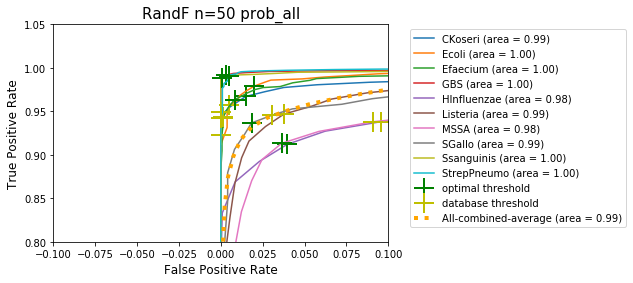

acc_thresh 0.6241568872008492
opt_threshold -0.6405470514299436
nearest difference: 0.0022177557139624327
opt_threshold -0.79456411880261
nearest difference: 0.0
opt_threshold -0.7999756508935869
nearest difference: 0.0
opt_threshold -1.1669381909826828
nearest difference: 0.0022177557139624327
opt_threshold -0.5160193902599897
nearest difference: 0.0
opt_threshold -0.5264843531352805
nearest difference: 0.0
opt_threshold -0.53418326406184
nearest difference: 0.0
opt_threshold -0.6219391314868867
nearest difference: 0.0
opt_threshold -1.1159300691873482
nearest difference: 0.0022177557139624327
opt_threshold -1.2220307410928357
nearest difference: 0.0022177557139624327


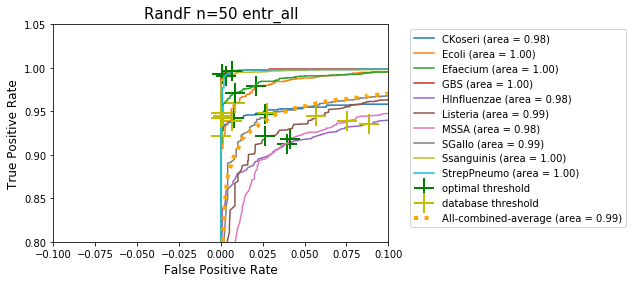

,species,method,novelty_method,optimal specificity,optimal sensitivity,optimal youden,real specificity,real sensitivity,real youden,youden difference (%)
0,CKoseri,RandF n=50,prob_all,0.985106,0.967115,0.952221,0.998884,0.976883,0.975767,2.472726
1,Ecoli,RandF n=50,prob_all,0.980075,0.978994,0.959069,0.998884,0.976883,0.975767,1.741088
2,Efaecium,RandF n=50,prob_all,0.991826,0.963558,0.955384,0.998884,0.976883,0.975767,2.133504
3,GBS,RandF n=50,prob_all,0.997120,0.991514,0.988634,0.998884,0.976883,0.975767,-1.301520
4,HInfluenzae,RandF n=50,prob_all,0.960307,0.912085,0.872392,0.998884,0.976883,0.975767,11.849604
5,Listeria,RandF n=50,prob_all,0.962354,0.946782,0.909136,0.998884,0.976883,0.975767,7.329035
6,MSSA,RandF n=50,prob_all,0.963728,0.913183,0.876911,0.998884,0.976883,0.975767,11.273199
7,SGallo,RandF n=50,prob_all,0.981689,0.936628,0.918316,0.998884,0.976883,0.975767,6.256078
8,Ssanguinis,RandF n=50,prob_all,0.999527,0.988680,0.988207,0.998983,0.976644,0.975626,-1.273067
9,StrepPneumo,RandF n=50,prob_all,0.995366,0.991019,0.986385,0.998884,0.976883,0.975767,-1.076457


In [320]:
save_optimal_vs_real = []
for method in classifiers_names[-3:-2]:
    for j,novelty_method in enumerate(['prob_all', 'entr_all']): #, 'prob_correct', 'entr_correct']):
        fprs = df_roc_curves[(df_roc_curves['method']==method) & (df_roc_curves['novelty_method']==novelty_method)]['fpr'].values
        tprs = df_roc_curves[(df_roc_curves['method']==method) & (df_roc_curves['novelty_method']==novelty_method)]['tpr'].values
        thresholds = df_roc_curves[(df_roc_curves['method']==method) & (df_roc_curves['novelty_method']==novelty_method)]['thresholds'].values

#         # First aggregate all false positive rates
#         all_fpr = np.unique(np.concatenate([fprs[i] for i in range(10)]))
        # Get accumulated_threshold
        acc_thresh = df_threshold_acc[(df_threshold_acc['method']==method) & (df_threshold_acc['novelty_method']==novelty_method) & (df_threshold_acc['weighted']==0)]['threshold'].values[0]
        print('acc_thresh', acc_thresh)

        
        plt.figure()
        for i in range(10):           
            # Plot main curve
            roc_auc = auc(fprs[i], tprs[i])
            plt.plot(fprs[i], tprs[i], label='%s (area = %0.2f)' %(labels[i],roc_auc))
            
             # Plot optimal threshold marker
            opt_threshold, opt_fpr_thresh, opt_tpr_thresh = get_thresh(tprs[i],fprs[i],thresholds[i])
            plt.plot(opt_fpr_thresh, opt_tpr_thresh, 'g+', mew=2, ms=20, label='optimal threshold' if i==9 else '')

            print('opt_threshold', opt_threshold)
#             # Interpolate tprs and thresholds
#             tprs_int = interp(all_fpr, fprs[i], tprs[i])
#             thresholds_int = interp(all_fpr, fprs[i], thresholds[i])
#             plt.plot(all_fpr, tprs_int, '--', label='%s (area = %0.2f)' %(labels[i],roc_auc))
            
#             print(thresholds[i])
            
            #  Find threshold near accumulated_threshold
            idx = find_nearest(thresholds[i], acc_thresh if(j%2 == 0) else -acc_thresh)
                 
            # Plot suboptimal accumulated_threshold marker
            plt.plot(fprs[i][idx], tprs[i][idx], 'y+', mew=2, ms=20, label='database threshold' if i==9 else '')      
            
            # Save data to compare optimal vs real threshold
            save_optimal_vs_real.append([labels[i], method, novelty_method, 1-opt_fpr_thresh, opt_tpr_thresh, opt_tpr_thresh-opt_fpr_thresh,1-all_fpr[idx], tprs_int[idx], tprs_int[idx]-all_fpr[idx]])

            
        # Plot ROC curve from accumulated experiments 
        fpr = df_threshold_acc[(df_threshold_acc['method']==method) & (df_threshold_acc['novelty_method']==novelty_method) & (df_threshold_acc['weighted']==0)]['fpr_acc'].values[0]
        tpr = df_threshold_acc[(df_threshold_acc['method']==method) & (df_threshold_acc['novelty_method']==novelty_method) & (df_threshold_acc['weighted']==0)]['tpr_acc'].values[0]
        roc_auc = df_threshold_acc[(df_threshold_acc['method']==method) & (df_threshold_acc['novelty_method']==novelty_method) & (df_threshold_acc['weighted']==0)]['auc'].values[0]
        plt.plot(fpr, tpr, label='All-combined-average (area = %0.2f)' %(roc_auc), color='orange', linestyle=':', linewidth=4)
       
        plt.plot([0, 1], [0, 1], color='black', linestyle='--')
        plt.xlim([-0.1, 0.1])
        plt.ylim([0.8, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(method+' '+novelty_method, fontsize=15)    
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        #     plt.savefig('Lennart Figures/LOO classifier comparison/ROC/'+method)
        plt.show()
        
spec_sens = pd.DataFrame(save_optimal_vs_real)
spec_sens.columns = ('species',"method",'novelty_method', "optimal specificity", "optimal sensitivity", "optimal youden", "real specificity", "real sensitivity", "real youden")
spec_sens['youden difference (%)'] = 100*(spec_sens['real youden'] - spec_sens['optimal youden'])/spec_sens['optimal youden']
# spec_sens.to_csv('Lennart Figures/uMelt validation/spec_sens.csv')
spec_sens

[2.   1.   0.98 0.96 0.94 0.92 0.9  0.88 0.86 0.84 0.82 0.8  0.78 0.76
 0.74 0.72 0.7  0.68 0.66 0.64 0.62 0.6  0.58 0.56 0.54 0.52 0.5  0.48
 0.46 0.44 0.42 0.4  0.38 0.36 0.34 0.3  0.28 0.24]
[0.88       0.86664773 0.86646508 0.86079019 0.86       0.8559283
 0.85386469 0.85293017 0.85131231 0.84852679 0.84158038 0.82
 0.81807749 0.8179549  0.8171041  0.81355283 0.81313175 0.80924313
 0.80910751 0.80754154 0.80745686 0.80488724 0.80325446 0.8021875
 0.80089912 0.8        0.79519345 0.79181959 0.79170146 0.78841641
 0.78824705 0.78715643 0.78654716 0.78310782 0.78       0.77986479
 0.77893023 0.77484789 0.77231331 0.77146299 0.77060335 0.77054209
 0.76993734 0.76262462 0.76       0.75991127 0.75918017 0.7586359
 0.75661732 0.75521432 0.75397635 0.75379325 0.75113169 0.75023161
 0.74953125 0.745629   0.74297433 0.74182732 0.74015722 0.74
 0.73922423 0.73887975 0.73422516 0.73357254 0.73246058 0.73200639
 0.72381812 0.72232003 0.72       0.71994204 0.71788092 0.71772077
 0.71482561 0.714

 0.2029789  0.20189297 0.20097554 0.20064053 0.2       ]
difference: 0.0
[2.   1.   0.98 0.96 0.94 0.92 0.9  0.88 0.86 0.84 0.82 0.78 0.76 0.74
 0.7  0.68 0.66 0.64 0.62 0.6  0.58 0.56 0.54 0.52 0.5  0.48 0.46 0.44
 0.42 0.4  0.38 0.36 0.34 0.32 0.3  0.28 0.26 0.24 0.22 0.2  0.18]
[0.64       0.62026989 0.62       0.61161444 0.61044681 0.60443022
 0.60138091 0.6        0.59940234 0.59837333 0.59580722 0.5952234
 0.59096217 0.59069045 0.58880468 0.58093331 0.58       0.57637091
 0.57624435 0.57478289 0.57470386 0.57230574 0.57078194 0.56978618
 0.5685838  0.56774468 0.56325893 0.56011024 0.56       0.55823484
 0.55814384 0.55755781 0.55723043 0.55538237 0.55371244 0.55362768
 0.55304182 0.55048266 0.54889377 0.54836072 0.54782181 0.54778341
 0.54740431 0.54282006 0.54117473 0.54104759 0.54       0.5395638
 0.53794603 0.5368216  0.53582944 0.5356827  0.53354961 0.53282825
 0.53226695 0.52913952 0.52701196 0.52609269 0.52475421 0.5246282
 0.52400647 0.52373038 0.52       0.51953941 0.5187

 0.29026786 0.28470213 0.28       0.27313175 0.26      ]
difference: 0.0
[2.   1.   0.98 0.96 0.94 0.92 0.9  0.88 0.86 0.84 0.82 0.8  0.78 0.76
 0.74 0.72 0.7  0.68 0.66 0.64 0.62 0.6  0.58 0.56 0.54 0.52 0.5  0.48
 0.46 0.44 0.42 0.4  0.38 0.36 0.34 0.3  0.28 0.24]
[2.         1.57575758 1.5699544  1.38964578 1.36453901 1.23516859
 1.16960148 1.13990881 1.08850458 1.         0.99705722 0.99638771
 0.99150097 0.99118937 0.98902679 0.98       0.97954129 0.97530518
 0.97515745 0.97345153 0.97335928 0.97056004 0.96878136 0.96761905
 0.96621554 0.96523607 0.96       0.95742725 0.95733717 0.95483215
 0.954703   0.95387135 0.95340674 0.95078406 0.94841418 0.9482939
 0.94746247 0.94383064 0.94157576 0.94081928 0.9400545  0.94
 0.9395109  0.9335966  0.93147389 0.93130986 0.92995833 0.92895219
 0.92522063 0.92262701 0.92033848 0.92       0.91507981 0.9134159
 0.91212121 0.90490746 0.9        0.89888932 0.89727213 0.89711989
 0.8963687  0.89603513 0.89152799 0.89089604 0.88981931 0.88937951
 0.8

 0.19571429 0.18998582 0.1851462  0.18337893 0.18      ]
difference: 0.19999999999999996
[2.   1.   0.98 0.96 0.94 0.92 0.9  0.88 0.86 0.84 0.82 0.8  0.78 0.76
 0.74 0.72 0.7  0.68 0.66 0.64 0.62 0.6  0.58 0.56 0.54 0.52 0.5  0.48
 0.46 0.44 0.42 0.4  0.38 0.36 0.34 0.32 0.3  0.28 0.26 0.24 0.22 0.2
 0.18]
[0.84       0.8297822  0.82964243 0.82529973 0.82469504 0.82157917
 0.72       0.71928486 0.7180468  0.71591518 0.71059946 0.70939007
 0.70056287 0.68       0.6780468  0.66989397 0.66892729 0.66
 0.65937733 0.65218718 0.65179837 0.6        0.59750104 0.59586806
 0.5938962  0.59252009 0.58516369 0.58       0.57972882 0.57218718
 0.57179837 0.56929459 0.56789586 0.56       0.5457305  0.54500623
 0.54       0.529066   0.52227746 0.52       0.51923252 0.51917783
 0.51863791 0.51210919 0.50976596 0.50958489 0.50809295 0.50698229
 0.50286306 0.5        0.49848423 0.49826004 0.49500125 0.49389918
 0.49304167 0.48826376 0.48501339 0.48360899 0.48156413 0.48137163
 0.48042178 0.48       0.475

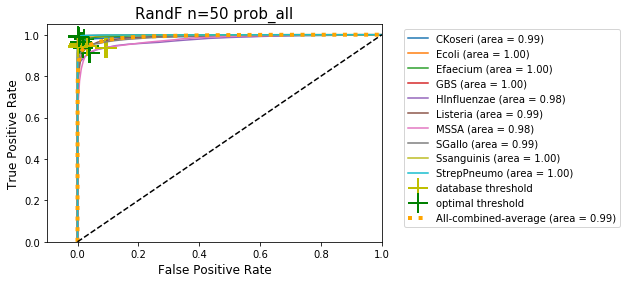

,species,method,novelty_method,optimal specificity,optimal sensitivity,optimal youden,real specificity,real sensitivity,real youden,youden difference (%)
0,CKoseri,RandF n=50,prob_all,0.985106,0.967115,0.952221,0.998638,0.941046,0.939684,-1.316612
1,Ecoli,RandF n=50,prob_all,0.980075,0.978994,0.959069,0.995019,0.957159,0.952177,-0.718542
2,Efaecium,RandF n=50,prob_all,0.991826,0.963558,0.955384,0.998638,0.943185,0.941823,-1.419434
3,GBS,RandF n=50,prob_all,0.997120,0.991514,0.988634,1.000000,0.986762,0.986762,-0.189396
4,HInfluenzae,RandF n=50,prob_all,0.960307,0.912085,0.872392,0.904396,0.938066,0.842463,-3.430723
5,Listeria,RandF n=50,prob_all,0.962354,0.946782,0.909136,0.962354,0.946782,0.909136,0.000000
6,MSSA,RandF n=50,prob_all,0.963728,0.913183,0.876911,0.909040,0.938030,0.847070,-3.402964
7,SGallo,RandF n=50,prob_all,0.981689,0.936628,0.918316,0.969481,0.945561,0.915042,-0.356519
8,Ssanguinis,RandF n=50,prob_all,0.999527,0.988680,0.988207,1.000000,0.986595,0.986595,-0.163094
9,StrepPneumo,RandF n=50,prob_all,0.995366,0.991019,0.986385,1.000000,0.942184,0.942184,-4.481144


In [287]:
save_optimal_vs_real = []
for method in classifiers_names[-3:-2]:
    for j,novelty_method in enumerate(['prob_all']): #, 'entr_all', 'prob_correct', 'entr_correct']):
        fprs = df_roc_curves[(df_roc_curves['method']==method) & (df_roc_curves['novelty_method']==novelty_method)]['fpr'].values
        tprs = df_roc_curves[(df_roc_curves['method']==method) & (df_roc_curves['novelty_method']==novelty_method)]['tpr'].values
        thresholds = df_roc_curves[(df_roc_curves['method']==method) & (df_roc_curves['novelty_method']==novelty_method)]['thresholds'].values

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fprs[i] for i in range(10)]))
        
        plt.figure()
        for i in range(10):           
            # Plot main curve
            roc_auc = auc(fprs[i], tprs[i])
            plt.plot(fprs[i], tprs[i], label='%s (area = %0.2f)' %(labels[i],roc_auc))

#             # Interpolate tprs and thresholds
#             tprs_int = interp(all_fpr, fprs[i], tprs[i])
#             thresholds_int = interp(all_fpr, fprs[i], thresholds[i])
                       
            # Find nearest threshold to accumulated_threshold
            acc_thresh = df_threshold_acc[(df_threshold_acc['method']==method) & (df_threshold_acc['novelty_method']==novelty_method) & (df_threshold_acc['weighted']==0)]['threshold'].values[0]
            idx = find_nearest(thresholds_int, acc_thresh if(j%2 == 0) else -acc_thresh)
            
            # Plot suboptimal accumulated_threshold marker
            plt.plot(all_fpr[idx], tprs_int[idx], 'y+', mew=2, ms=20, label='database threshold' if i==9 else '')
     
            # Plot optimal threshold marker
            opt_threshold, opt_fpr_thresh, opt_tpr_thresh = get_thresh(tprs_int,all_fpr,thresholds_int)
            plt.plot(opt_fpr_thresh, opt_tpr_thresh, 'g+', mew=2, ms=20, label='optimal threshold' if i==9 else '')
            
            # Save data to compare optimal vs real threshold
            save_optimal_vs_real.append([labels[i], method, novelty_method, 1-opt_fpr_thresh, opt_tpr_thresh, opt_tpr_thresh-opt_fpr_thresh,1-all_fpr[idx], tprs_int[idx], tprs_int[idx]-all_fpr[idx]])

            
        # Plot ROC curve from accumulated experiments 
        fpr = df_threshold_acc[(df_threshold_acc['method']==method) & (df_threshold_acc['novelty_method']==novelty_method) & (df_threshold_acc['weighted']==0)]['fpr_acc'].values[0]
        tpr = df_threshold_acc[(df_threshold_acc['method']==method) & (df_threshold_acc['novelty_method']==novelty_method) & (df_threshold_acc['weighted']==0)]['tpr_acc'].values[0]
        roc_auc = df_threshold_acc[(df_threshold_acc['method']==method) & (df_threshold_acc['novelty_method']==novelty_method) & (df_threshold_acc['weighted']==0)]['auc'].values[0]
        plt.plot(fpr, tpr, label='All-combined-average (area = %0.2f)' %(roc_auc), color='orange', linestyle=':', linewidth=4)
       
        plt.plot([0, 1], [0, 1], color='black', linestyle='--')
        plt.xlim([-0.1, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(method+' '+novelty_method, fontsize=15)    
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        #     plt.savefig('Lennart Figures/LOO classifier comparison/ROC/'+method)
        plt.show()
        
spec_sens = pd.DataFrame(save_optimal_vs_real)
spec_sens.columns = ('species',"method",'novelty_method', "optimal specificity", "optimal sensitivity", "optimal youden", "real specificity", "real sensitivity", "real youden")
spec_sens['youden difference (%)'] = 100*(spec_sens['real youden'] - spec_sens['optimal youden'])/spec_sens['optimal youden']
# spec_sens.to_csv('Lennart Figures/uMelt validation/spec_sens.csv')
spec_sens

### Output for Article

In [212]:
spec_sens[spec_sens['novelty_method'] == 'prob_all']

,species,method,novelty_method,optimal specificity,optimal sensitivity,optimal youden,real specificity,real sensitivity,real youden,youden difference (%)
0,CKoseri,RandF n=50,prob_all,0.985106,0.967115,0.952221,0.998638,0.941046,0.939684,-1.316612
1,Ecoli,RandF n=50,prob_all,0.980075,0.978994,0.959069,0.995019,0.957159,0.952177,-0.718542
2,Efaecium,RandF n=50,prob_all,0.991826,0.963558,0.955384,0.998638,0.943185,0.941823,-1.419434
3,GBS,RandF n=50,prob_all,0.997120,0.991514,0.988634,1.000000,0.986762,0.986762,-0.189396
4,HInfluenzae,RandF n=50,prob_all,0.960307,0.912085,0.872392,0.904396,0.938066,0.842463,-3.430723
5,Listeria,RandF n=50,prob_all,0.962354,0.946782,0.909136,0.962354,0.946782,0.909136,0.000000
6,MSSA,RandF n=50,prob_all,0.963728,0.913183,0.876911,0.909040,0.938030,0.847070,-3.402964
7,SGallo,RandF n=50,prob_all,0.981689,0.936628,0.918316,0.969481,0.945561,0.915042,-0.356519
8,Ssanguinis,RandF n=50,prob_all,0.999527,0.988680,0.988207,1.000000,0.986595,0.986595,-0.163094
9,StrepPneumo,RandF n=50,prob_all,0.995366,0.991019,0.986385,1.000000,0.942184,0.942184,-4.481144


# CalibratedClassifierCV on all classifiers

(13986, 400) (4907, 400) (13986,) (4907,)


No handles with labels found to put in legend.


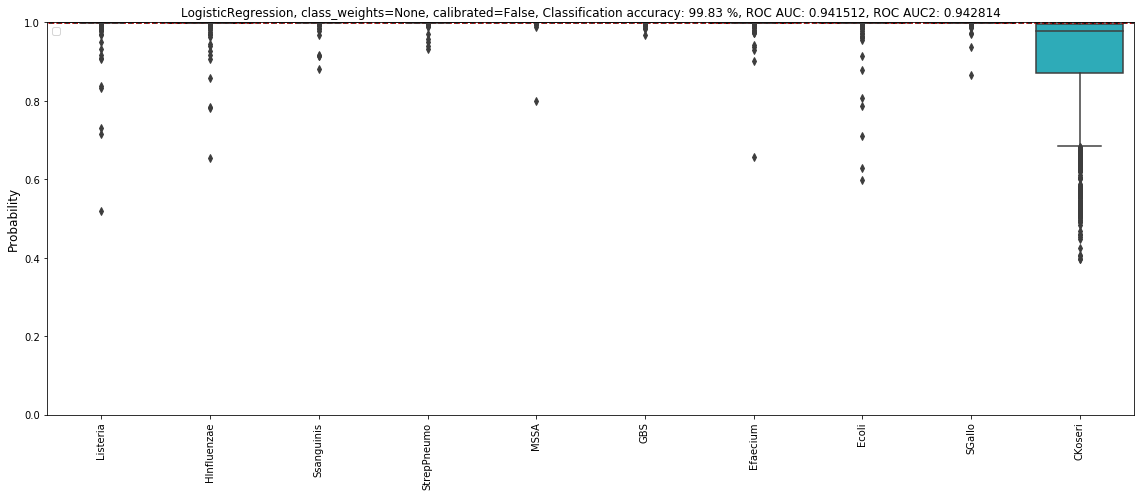

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true

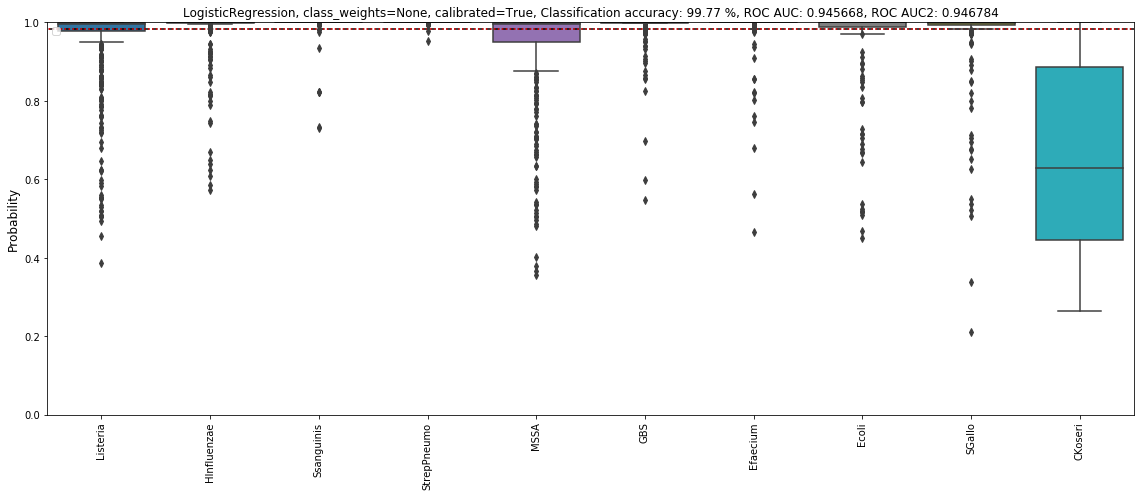

No handles with labels found to put in legend.


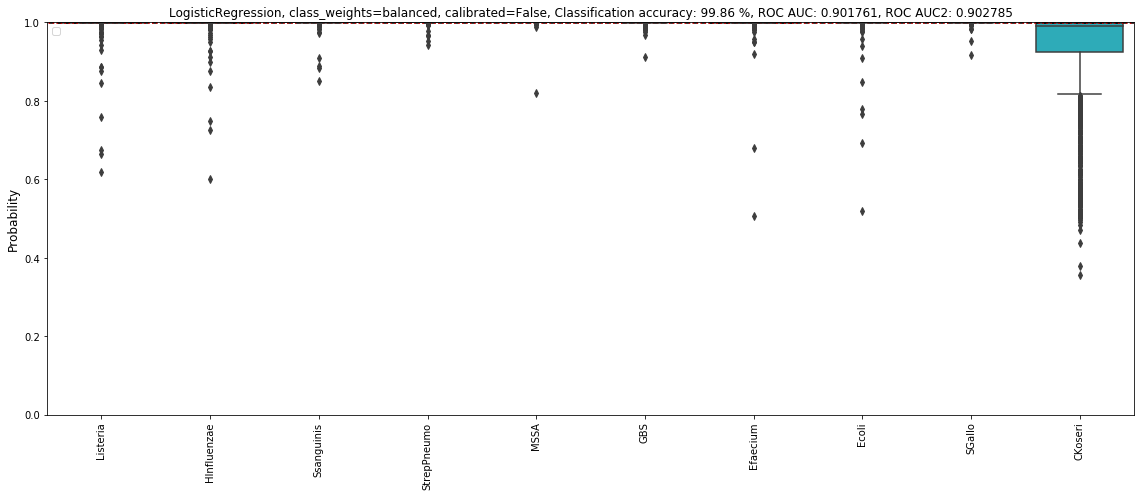

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true

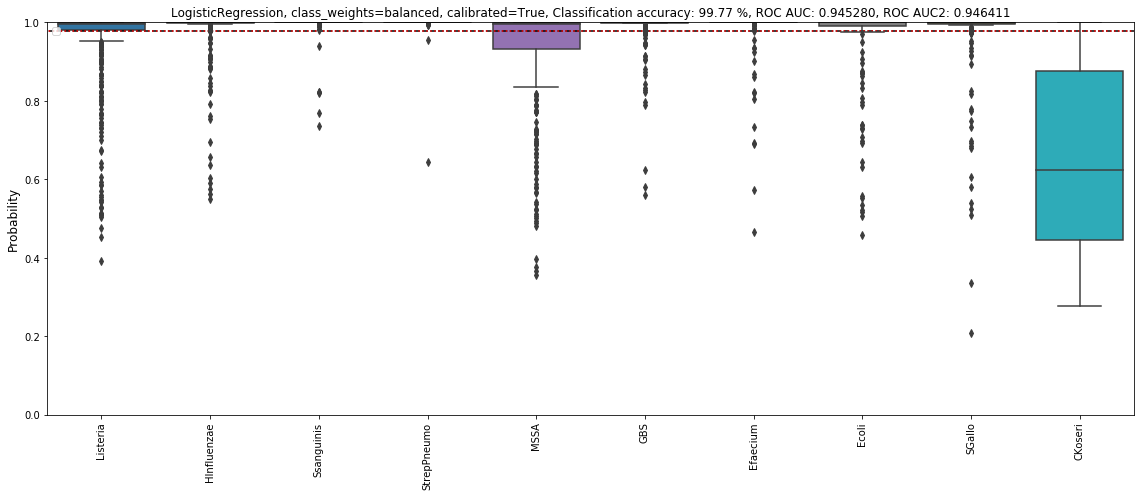

No handles with labels found to put in legend.


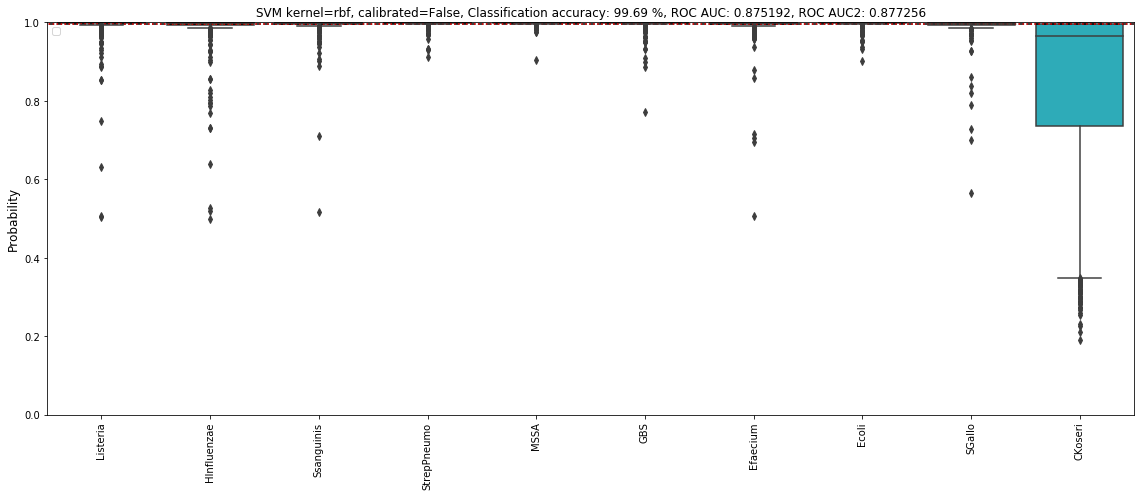

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

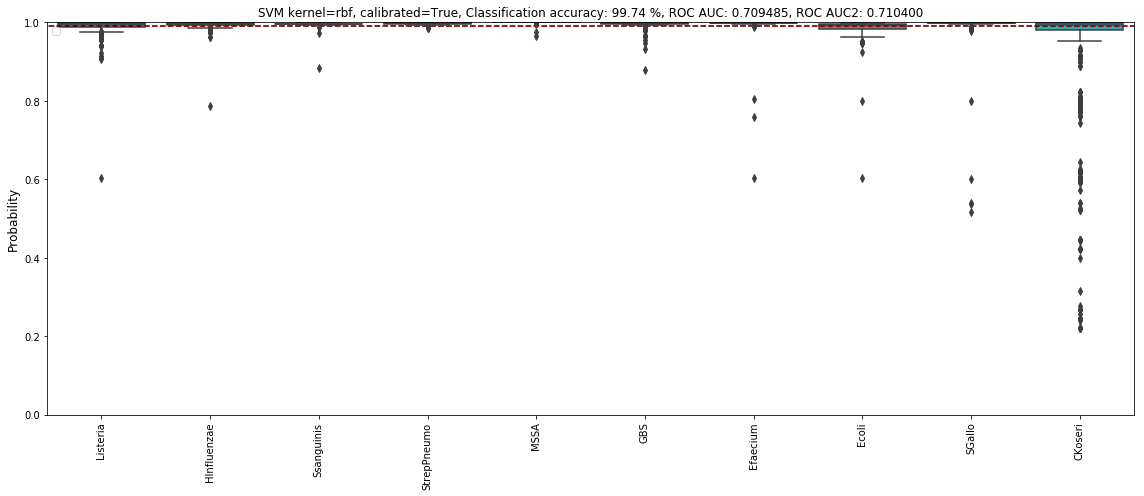

No handles with labels found to put in legend.


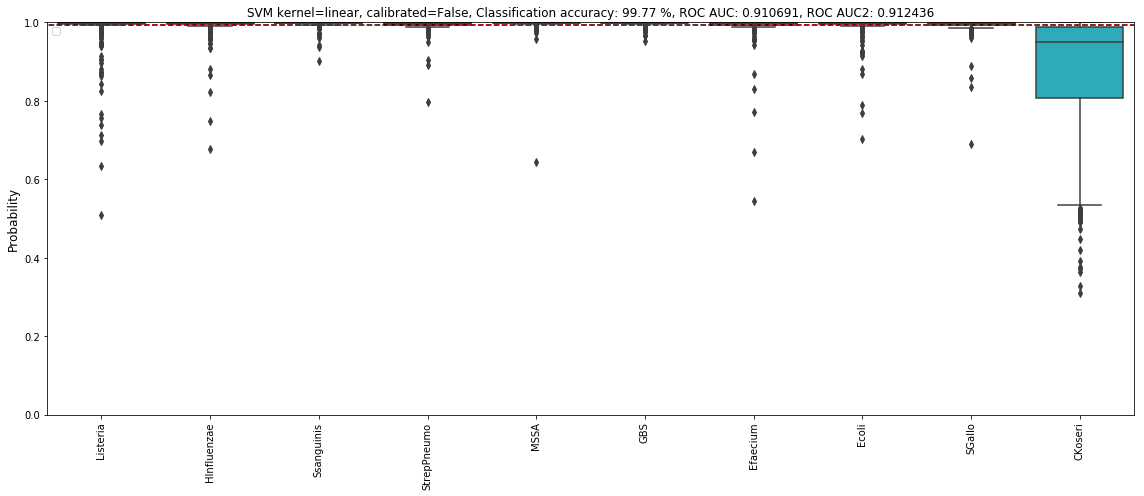

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true

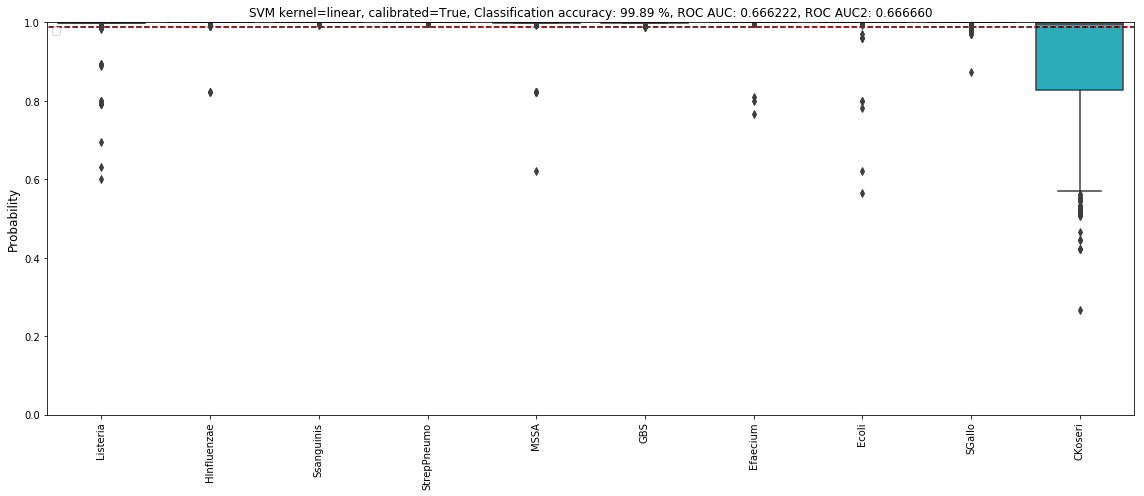

No handles with labels found to put in legend.


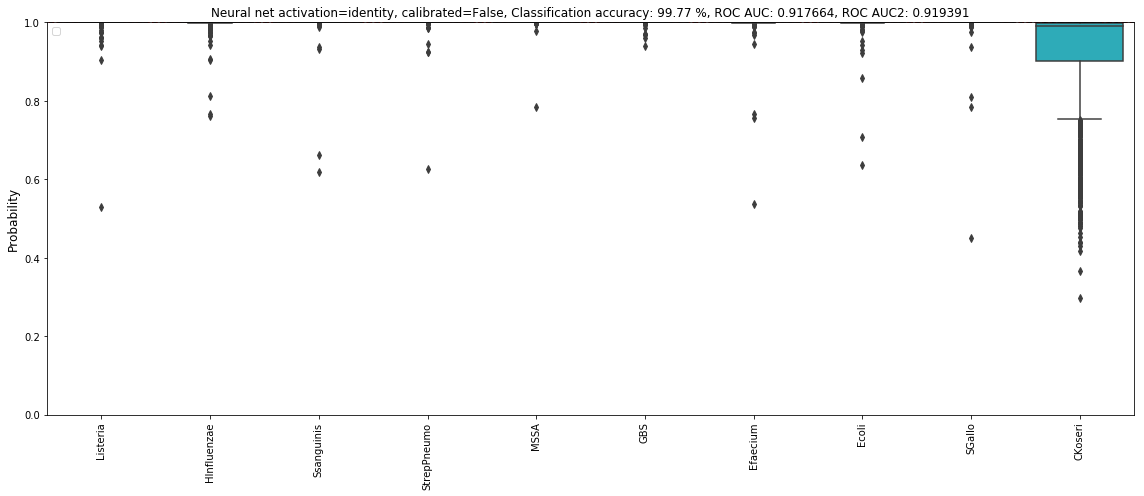

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
No handles with labels found to put in legend.


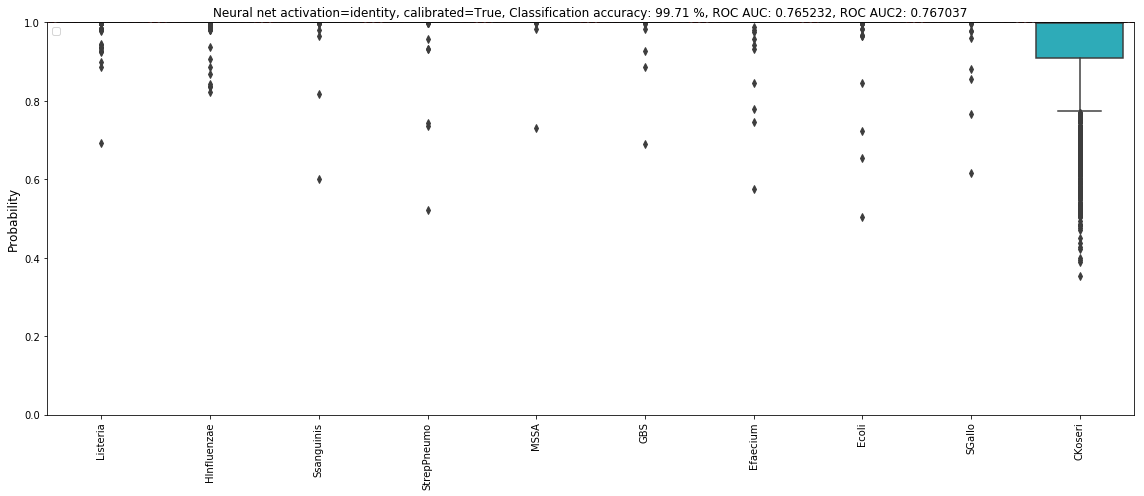

No handles with labels found to put in legend.


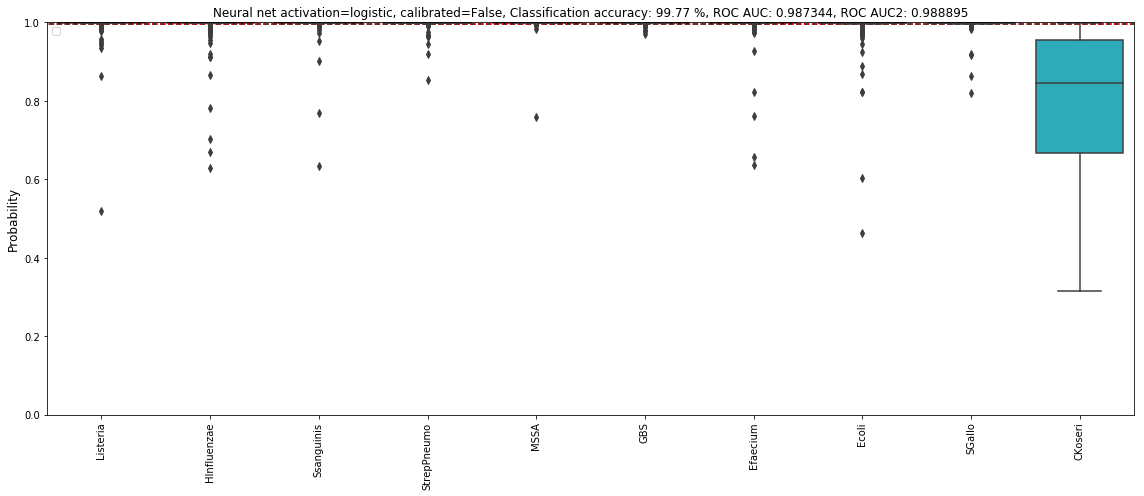

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
No handles with labels found to put in legend.


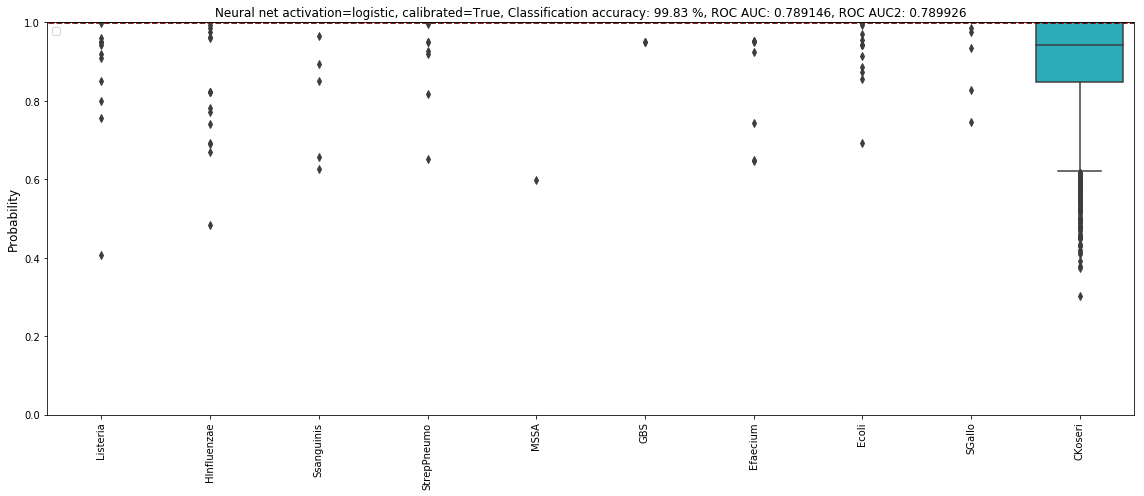

No handles with labels found to put in legend.


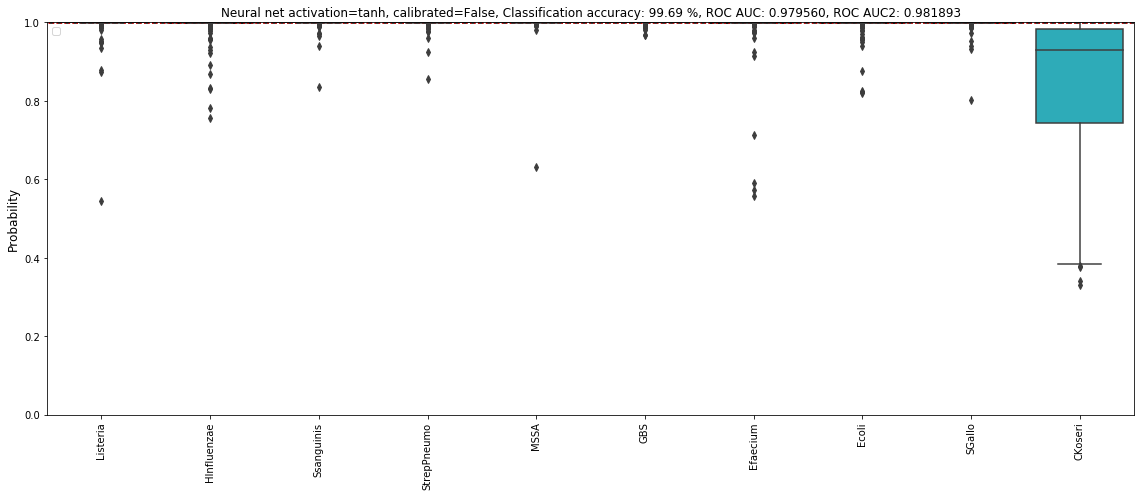

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true

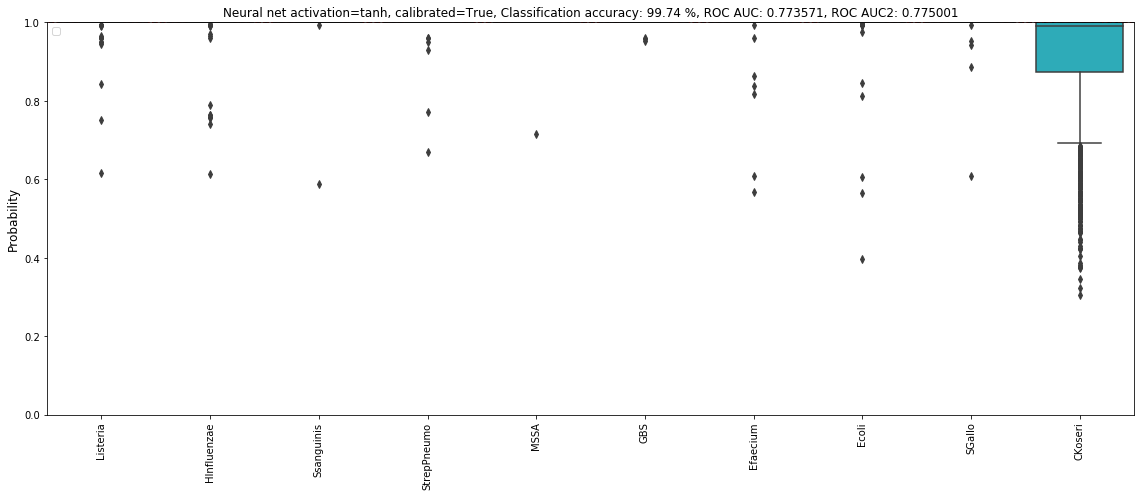

No handles with labels found to put in legend.


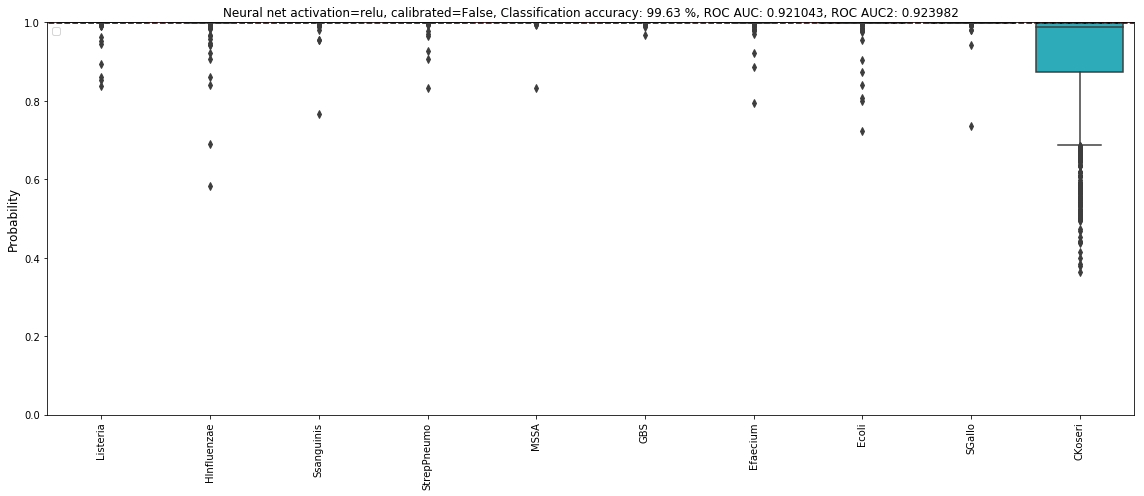

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true

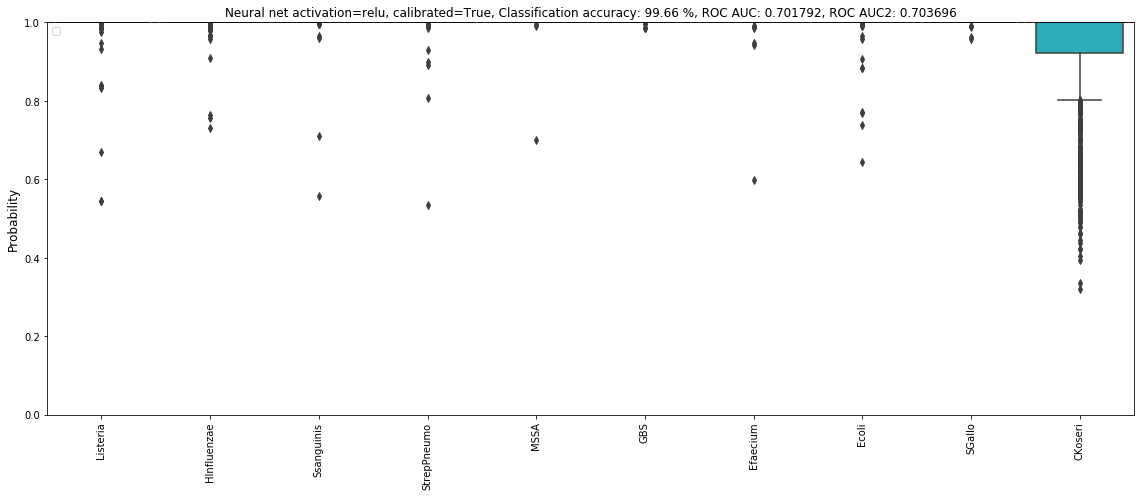

No handles with labels found to put in legend.


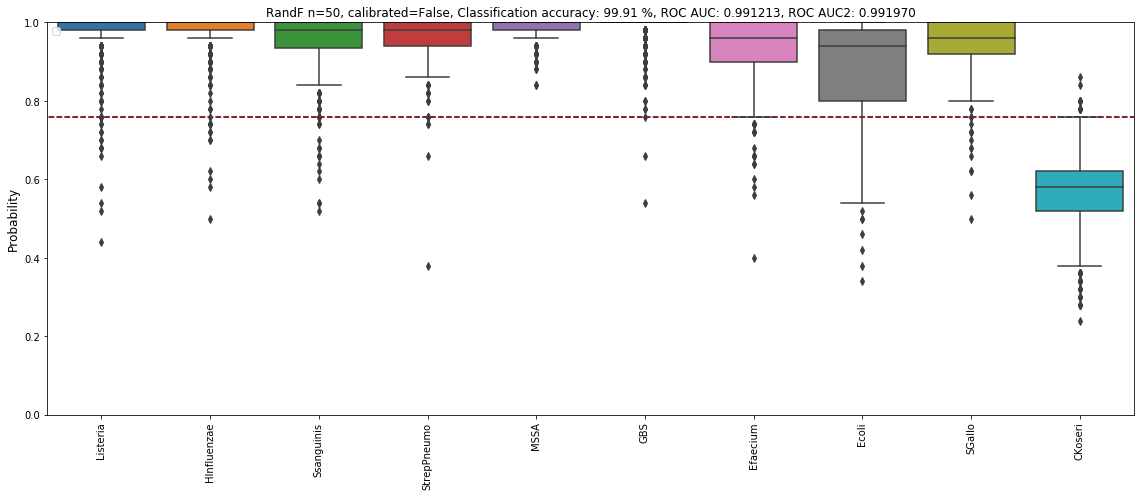

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
No handles with labels found to put in legend.


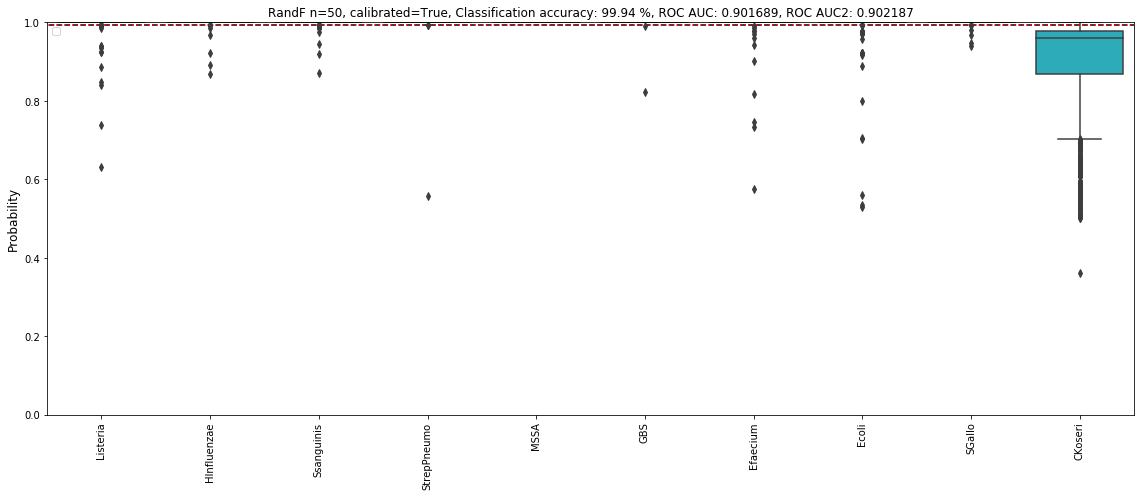

No handles with labels found to put in legend.


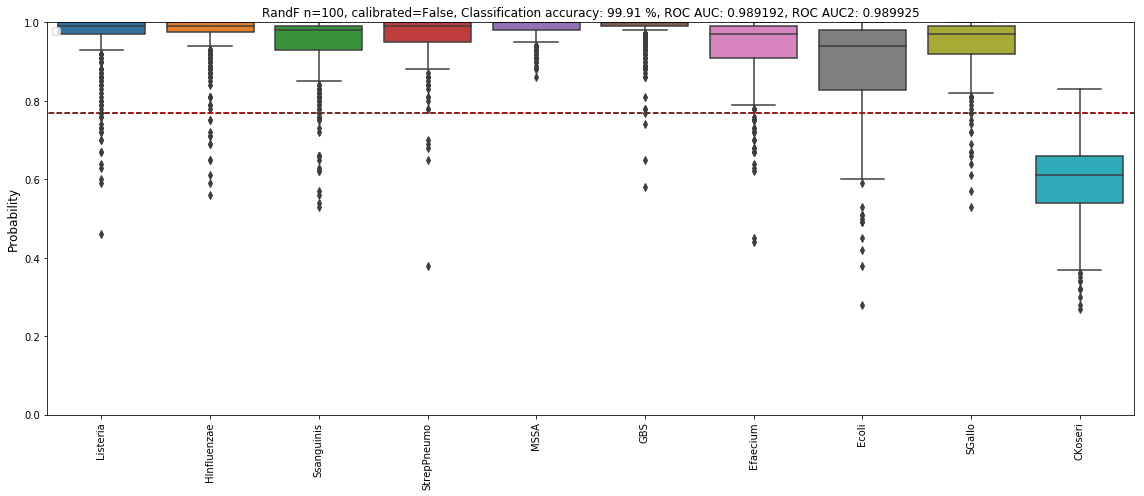

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
No handles with labels found to put in legend.


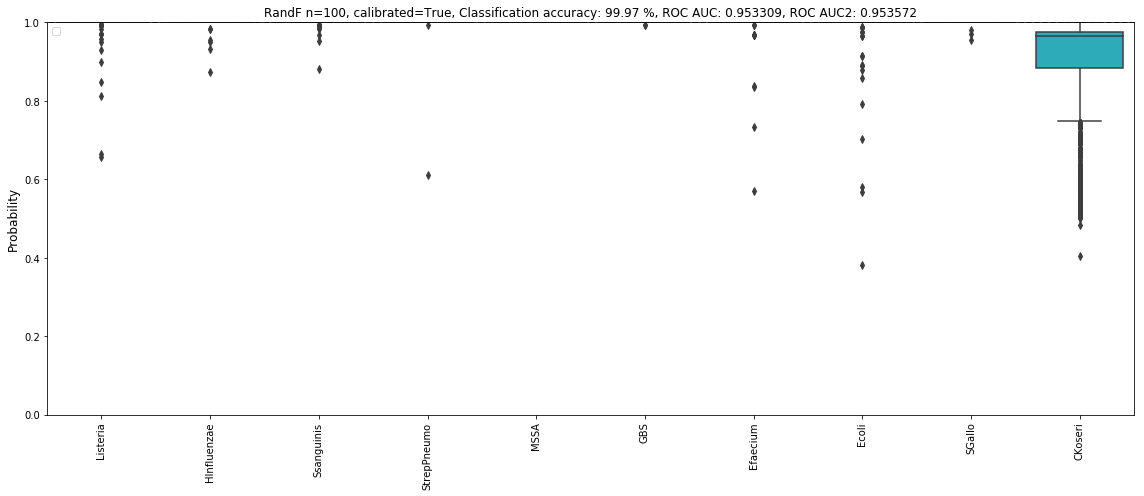

No handles with labels found to put in legend.


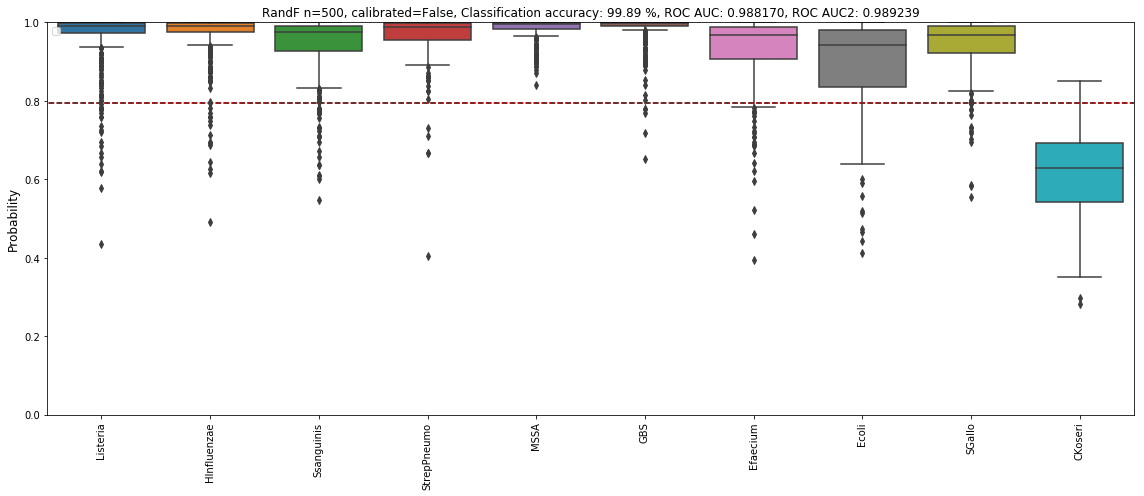

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:392: RuntimeWarning: invalid value encountered in true

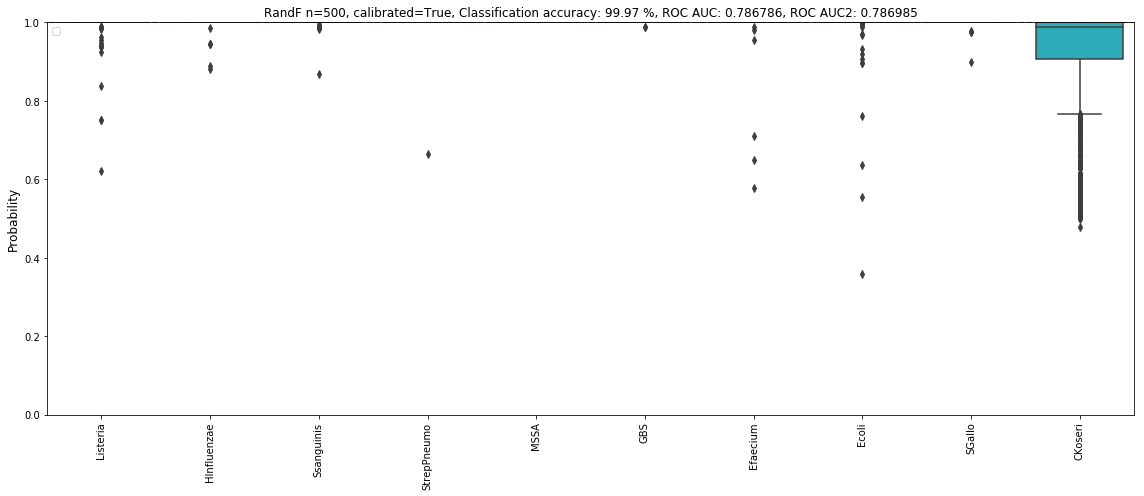

No handles with labels found to put in legend.


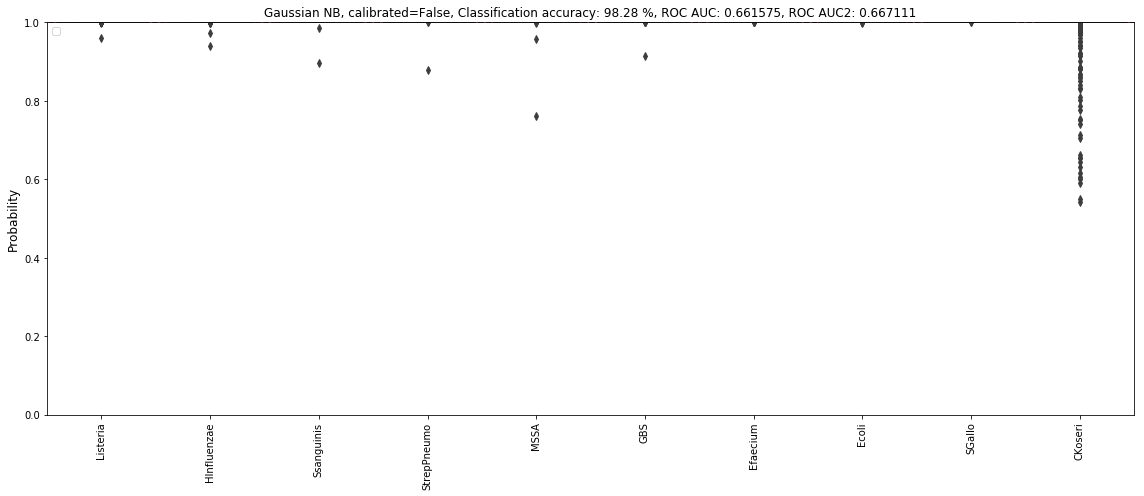

No handles with labels found to put in legend.


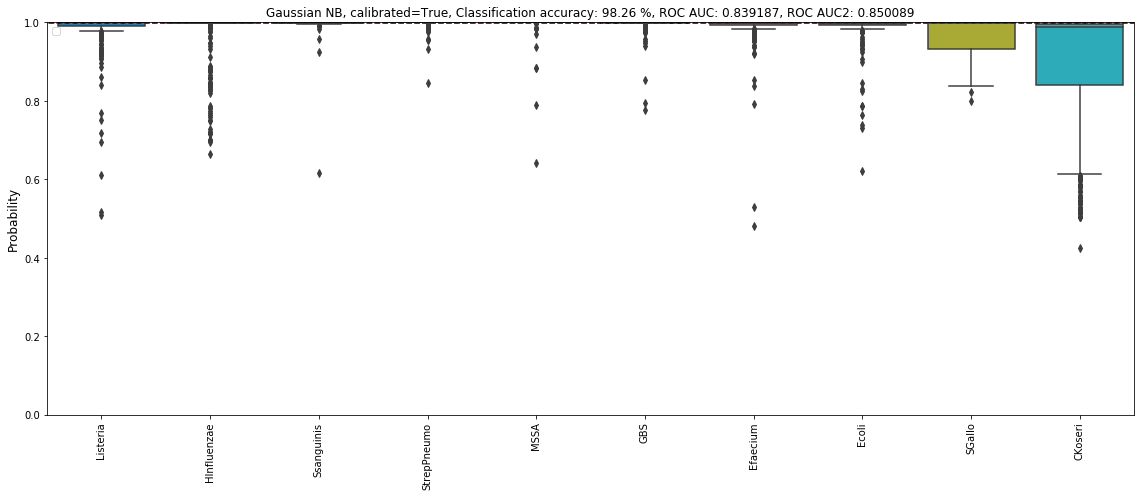

In [102]:
labels = list(np.unique(df_all_alignedbyOrg_1_auc_norm.index.values))

save = []
accumulate = []
roc_curves = []
test_size = []
fig_save = []
for label in labels[:1]:

    df_LOO = df_all_alignedbyOrg_1_auc_norm.iloc[:,:-10].drop(label)
    X_train, X_test, y_train, y_test = train_test_split(df_LOO, df_LOO.index, test_size=0.2, random_state=42)
    known_length = len(X_test)
    unknown_length = len(df_all_alignedbyOrg_1_auc_norm.loc[label].iloc[:,:-10])
    test_size.append([label,known_length,unknown_length])
    
    X_test = X_test.append(df_all_alignedbyOrg_1_auc_norm.loc[label].iloc[:,:-10])
    y_test = y_test.append(df_all_alignedbyOrg_1_auc_norm.loc[label].index)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    standardizer = StandardScaler()
    standardizer.fit(X_train)
    X_train_std = standardizer.transform(X_train)
    X_test_std = standardizer.transform(X_test)
    X_train_std = np.nan_to_num(X_train_std)
    X_test_std = np.nan_to_num(X_test_std)

    for clf, clf_name in zip(classifiers,classifiers_names):
        
        for i in range(2):

            start_time = time.time()
            if(i==0): model_fit = clf.fit(X_train_std, y_train)
            else:   
                calibrated_clf = CalibratedClassifierCV(base_estimator=clf, method='isotonic', cv=5)
                model_fit = calibrated_clf.fit(X_train_std, y_train)
            fit_time = time.time()-start_time

            df_out = pd.DataFrame(data=None, index=X_test.index)

            start_time = time.time()
            pred=model_fit.predict(X_test_std)
            predict_time = time.time()-start_time

            df_out['Prediction'] = pred
            prob = model_fit.predict_proba(X_test_std)
            df_out['Probability'] = np.max(prob, axis=1)
            df_out['Entropy']= entropy(prob.T)
            df_out['Correct'] = (df_out.index == df_out['Prediction'])
            accuracy = sum(df_out['Correct'])/known_length

            df_out['Known'] = False
            df_out['Known'].iloc[:known_length] = True

            # Only correctly classified ones
            df_out2 = df_out.loc[df_out['Correct'] == True].append(df_out.iloc[known_length:])

            fpr1, tpr1, thresholds1, auc1, threshold1 = get_roc(df_out['Known'].values, df_out['Probability'].values)
            fpr2, tpr2, thresholds2, auc2, threshold2 = get_roc(df_out['Known'].values, -df_out['Entropy'].values)
            fpr3, tpr3, thresholds3, auc3, threshold3 = get_roc(df_out2['Known'].values, df_out2['Probability'].values)
            fpr4, tpr4, thresholds4, auc4, threshold4 = get_roc(df_out2['Known'].values, -df_out2['Entropy'].values)


    #         plt.figure()
    #         plt.plot(fpr1, tpr1, label='prob (area = %f)' %(auc1))
    #         plt.plot(fpr2, tpr2, label='entropy (area = %f)' %(auc2))
    #         plt.plot(fpr3, tpr3, label='prob2 (area = %f)' %(auc3))
    #         plt.plot(fpr4, tpr4, label='entropy2 (area = %f)' %(auc4))
    #         plt.legend()
    #         plt.show()

            # Save data (old version)
    #         save2.append([label, clf_name, df_out['Known'].values, df_out['Probability'].values, compute_sample_weight(class_weight='balanced', y=df_out['Known'])])
    #         save.append([label, clf_name, fit_time, predict_time, auc1, auc3, threshold1, threshold3])
    #         roc_curves.append([label, clf_name, fpr1, tpr1, thresholds1, fpr3, tpr3, thresholds3])

            # Save data (updated)
#             save.append([label, clf_name, fit_time, predict_time, auc1, auc2, auc3, auc4])
            save.append([label, clf_name, bool(i), fit_time, predict_time, accuracy, auc1, auc2, auc3, auc4])


    #         accumulate.append([label, clf_name, 'prob_all', df_out['Known'].values, df_out['Probability'].values, compute_sample_weight(class_weight='balanced', y=df_out['Known'])])
    #         accumulate.append([label, clf_name, 'entr_all', df_out['Known'].values, -df_out['Entropy'].values, compute_sample_weight(class_weight='balanced', y=df_out['Known'])])
    #         accumulate.append([label, clf_name, 'prob_correct', df_out2['Known'].values, df_out2['Probability'].values, compute_sample_weight(class_weight='balanced', y=df_out2['Known'])])
    #         accumulate.append([label, clf_name, 'entr_correct', df_out2['Known'].values, -df_out2['Entropy'].values, compute_sample_weight(class_weight='balanced', y=df_out2['Known'])])

    #         roc_curves.append([label, clf_name, 'prob_all', fpr1, tpr1, thresholds1, auc1, threshold1])
    #         roc_curves.append([label, clf_name, 'entr_all', fpr2, tpr2, thresholds2, auc2, -threshold2])
    #         roc_curves.append([label, clf_name, 'prob_correct', fpr3, tpr3, thresholds3, auc3, threshold3])
    #         roc_curves.append([label, clf_name, 'entr_correct', fpr4, tpr4, thresholds4, auc4, -threshold4])       

    #         fig_save.append([label, clf_name, 'prob_all', df_out.index, df_out['Probability'], auc1, threshold1])
    #         fig_save.append([label, clf_name, 'entr_all', df_out.index, df_out['Entropy'], auc2, -threshold2])
    #         fig_save.append([label, clf_name, 'prob_correct', df_out2.index, df_out2['Probability'], auc3, threshold3])
    #         fig_save.append([label, clf_name, 'entr_correct', df_out2.index, df_out2['Entropy'], auc4, -threshold4])


            # figure for probability boxplot
            plt.figure(figsize=(16,7))
            ax = sns.boxplot(x=df_out2.index, y=df_out2['Probability'], dodge=False, showfliers=True)
            plt.ylim(0, 1)
            plt.legend(loc='upper left')
            plt.ylabel('Probability', fontsize=12)
            plt.xticks((np.arange(10)), rotation='vertical')
            ax.xaxis.label.set_visible(False)
            plt.title('%s, calibrated=%s, Classification accuracy: %.2f %%, ROC AUC: %f, ROC AUC2: %f' %(clf_name, str(bool(i)), accuracy*100, auc1, auc3))
            plt.hlines(y=threshold1, xmin=-1, xmax=10, color='k', linestyle='dashed')
            plt.hlines(y=threshold3, xmin=-1, xmax=10, color='red', linestyle='dotted')
            plt.tight_layout()
#             plt.savefig('Lennart Figures/LOO classifier comparison3/'+label+', '+clf_name+', calibrated='+str(bool(i)))
            plt.show()

    #         # separate figure for entropy boxplot
    #         plt.figure(figsize=(16,7))
    #         ax = sns.boxplot(x=df_out2.index, y=df_out2['Entropy'], dodge=False, showfliers=True)
    #         ymax = entropy([0.1 for i in range(10)])
    #         plt.ylim(0, ymax)        
    #         plt.legend(loc='upper left')
    #         plt.ylabel('Entropy', fontsize=12)
    #         plt.xticks((np.arange(10)), rotation='vertical')
    #         ax.xaxis.label.set_visible(False)
    #         plt.title('%s, Classification accuracy: %.2f %%, ROC AUC: %f, ROC AUC2: %f' %(clf_name, accuracy*100, auc2, auc4))
    #         plt.hlines(y=-threshold2, xmin=-1, xmax=66, color='k', linestyle='dashed')
    #         plt.hlines(y=-threshold4, xmin=-1, xmax=66, color='red', linestyle='dotted')
    #         plt.tight_layout()
    #         plt.savefig('Lennart Figures/LOO classifier comparison2/kNN/calibrated/entropy '+label+', '+clf_name)
    #         plt.show()
        
       
# Save all data as pickle and csv's
results = pd.DataFrame(save)
results.columns = ("species", "method", "calibrated", "fit_time", "predict_time", "accuracy", "roc_auc1", "roc_auc2", "roc_auc3", "roc_auc4")
results.to_csv('Lennart Figures/LOO classifier comparison3/results_isotonic.csv')

# df_summary=pd.DataFrame()
# for i,method in enumerate(classifiers_names):
#     df_summary=df_summary.append(results[results['method']==method].mean(),ignore_index=True)
# df_summary.index = classifiers_names
# df_summary.to_csv('Lennart Figures/LOO classifier comparison2/kNN/calibrated/results_summary.csv')

# df_accumulate = pd.DataFrame(accumulate)
# df_accumulate.columns = ("species", "method", 'novelty_method','Known','Probability', 'weights')
# df_accumulate.to_pickle('Lennart Figures/LOO classifier comparison2/kNN/calibrated/accumulate.pkl')

# df_roc_curves = pd.DataFrame(roc_curves)
# df_roc_curves.columns = ("species", "method", 'novelty_method', 'fpr', 'tpr', 'thresholds', 'auc', 'threshold')
# df_roc_curves.to_pickle('Lennart Figures/LOO classifier comparison2/kNN/calibrated/roc_curves.pkl')

# df_fig_save = pd.DataFrame(fig_save)
# df_fig_save.columns = ("species", "method", 'novelty_method', 'index', 'score', 'auc', 'threshold')
# df_fig.to_pickle('Lennart Figures/LOO classifier comparison2/kNN/calibrated/fig_save.pkl')

In [104]:
results_extra = results.copy()
results_extra.insert(3,'calibration improvement (%)', 0)
results_extra['calibration improvement (%)'] = results_extra.roc_auc1.pct_change()[1::2]*100
results_extra.to_csv('Lennart Figures/LOO classifier comparison3/results_extra_isotonic.csv')
results_extra


,species,method,calibrated,calibration improvement (%),fit_time,predict_time,accuracy,roc_auc1,roc_auc2,roc_auc3,roc_auc4
0,CKoseri,"LogisticRegression, class_weights=None",False,NaN,17.161359,0.000000,0.998284,0.941512,0.940957,0.942814,0.942234
1,CKoseri,"LogisticRegression, class_weights=None",True,0.441390,65.289199,0.077528,0.997712,0.945668,0.943852,0.946784,0.944829
2,CKoseri,"LogisticRegression, class_weights=balanced",False,NaN,16.105668,0.000000,0.998570,0.901761,0.900950,0.902785,0.901965
3,CKoseri,"LogisticRegression, class_weights=balanced",True,4.826079,68.680219,0.073798,0.997712,0.945280,0.942755,0.946411,0.943846
4,CKoseri,SVM kernel=rbf,False,NaN,120.534249,9.034965,0.996854,0.875192,0.869709,0.877256,0.871683
5,CKoseri,SVM kernel=rbf,True,-18.933837,436.705912,38.866406,0.997426,0.709485,0.705734,0.710400,0.706675
6,CKoseri,SVM kernel=linear,False,NaN,26.770196,2.703241,0.997712,0.910691,0.905215,0.912436,0.906924
7,CKoseri,SVM kernel=linear,True,-26.844403,105.816514,12.968019,0.998856,0.666222,0.665615,0.666660,0.666049
8,CKoseri,Neural net activation=identity,False,NaN,9.190733,0.015621,0.997712,0.917664,0.917762,0.919391,0.919492
9,CKoseri,Neural net activation=identity,True,-16.610789,38.772694,0.071228,0.997140,0.765232,0.765425,0.767037,0.767187


# 3) uMelts for extra validation

In [98]:
# df_50_norm_noisy = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Publications/2. Probabilistic novelty detection/Data/df_50_norm_noisy.csv', index_col=0)

all_dfs = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Publications/2. Probabilistic novelty detection/Data/all_dfs.csv', index_col=0)
df_50_norm = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Publications/2. Probabilistic novelty detection/Data/df_50_norm.csv', index_col=0)
df_50_norm_noisy = pd.read_csv('//172.16.236.148/meltanalysis2/Lennart/Publications/2. Probabilistic novelty detection/Data/df_50_norm_noisy(noise_models).csv', index_col=0)

In [99]:
# df_all_alignedbyOrg_1_auc_norm.columns = df_all_alignedbyOrg_1_auc_norm.columns.map(float)
df_50_norm_noisy.columns = df_50_norm_noisy.columns.map(float)
df_50_norm.columns = df_50_norm.columns.map(float)
all_dfs.columns = all_dfs.columns.map(float)

In [107]:
settings = 0
plot=False
for noisy_df in [df_50_norm_noisy]: # [df_50_norm, df_50_norm_noisy]:
    for i in [0,240,0,240,0,240]:

        X_train, X_test, y_train, y_test = train_test_split(all_dfs.drop('E. coli').iloc[:,i:], all_dfs.drop('E. coli').index, test_size=0.2, random_state=42)
        known_length = len(X_test)
        print(X_test.shape)
        print(noisy_df.iloc[:,i:].shape)
        X_test = X_test.append(noisy_df.iloc[:,i:])
        y_test = y_test.append(noisy_df.index)
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        standardizer = StandardScaler()
        standardizer.fit(X_train)
        X_train_std = standardizer.transform(X_train)
        X_test_std = standardizer.transform(X_test)
        X_train_std = np.nan_to_num(X_train_std)
        X_test_std = np.nan_to_num(X_test_std)

        roc_curves = []
        fig_save = []
        for clf, clf_name in zip(classifiers,classifiers_names):
            
            if settings in [2,3]:
                clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid') 
            if settings in [4,5]:
                clf = CalibratedClassifierCV(base_estimator=clf, method='isotonic')

            model_fit = clf.fit(X_train_std, y_train)

            df_out = pd.DataFrame(data=None, index=X_test.index)
            pred=model_fit.predict(X_test_std)
            df_out['Prediction'] = pred
            prob = model_fit.predict_proba(X_test_std)
            df_out['Probability'] = np.max(prob, axis=1)
            df_out['Entropy']= entropy(prob.T)
            df_out['Correct'] = (df_out.index == df_out['Prediction'])

            df_out['Known'] = False
            df_out['Known'].iloc[:known_length] = True

        #     df_out2 = df_out.loc[df_out['Correct'] == True].append(df_out.iloc[-5600:])
            accuracy = sum(df_out['Correct'])/(len(df_out)-50)

            # Get ROC curve and AUC values
            fpr1, tpr1, thresholds1, auc1, threshold1 = get_roc(df_out['Known'].values, df_out['Probability'].values)
            fpr2, tpr2, thresholds2, auc2, threshold2 = get_roc(df_out['Known'].values, -df_out['Entropy'].values)

            if(plot):
                plt.figure(figsize=(16,7))
                ax = sns.boxplot(x=df_out.index, y=df_out['Probability'], dodge=False, showfliers=False)

                plt.ylim(0.0, 1.1)
                plt.legend(loc='upper left')
                plt.ylabel('Probability', fontsize=12)
                plt.xticks((np.arange(60)), rotation='vertical')
                ax.xaxis.label.set_visible(False)
                plt.title('%s, Classification accuracy: %.2f %%' %(clf_name, accuracy*100))
                plt.show()

            roc_curves.append([clf_name, 'prob_all', fpr1, tpr1, thresholds1, auc1, threshold1])
            roc_curves.append([clf_name, 'entr_all', fpr2, tpr2, thresholds2, auc2, -threshold2])
            fig_save.append([clf_name, 'prob_all', df_out.index, df_out['Probability'], auc1, threshold1, accuracy])
            fig_save.append([clf_name, 'entropy_all', df_out.index, df_out['Entropy'], auc2, -threshold2, accuracy])


        df_fig_save = pd.DataFrame(fig_save)
        df_fig_save.columns = ('method','novelty_method', 'index', 'score','auc','threshold','accuracy')
        df_fig_save.to_pickle(save_folder+'uMelt_fig_save'+str(settings)+'.pkl')

        df_roc_curves = pd.DataFrame(roc_curves)
        df_roc_curves.columns = ('method', 'novelty_method', 'fpr', 'tpr', 'thresholds', 'auc', 'threshold')
        df_roc_curves.to_pickle(save_folder+'uMelt_roc_curves'+str(settings)+'.pkl')
        
        settings += 1

(3488, 410)
(5000, 410)
(13950, 410) (8488, 410) (13950,) (8488,)
(3488, 170)
(5000, 170)
(13950, 170) (8488, 170) (13950,) (8488,)
(3488, 410)
(5000, 410)
(13950, 410) (8488, 410) (13950,) (8488,)
(3488, 170)
(5000, 170)
(13950, 170) (8488, 170) (13950,) (8488,)
(3488, 410)
(5000, 410)
(13950, 410) (8488, 410) (13950,) (8488,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

(3488, 170)
(5000, 170)
(13950, 170) (8488, 170) (13950,) (8488,)


C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F

C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\FraleyLab\AppData\Roaming\Python\Python37\site-packages\sklearn\calibration.py:381: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\F